# Preprocessing and registration
This notebook does basic preprocessing and registration dragonfly multiresolution data

v00 is just getting set up

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import os
from glob import glob
from os.path import join,split,splitext
import time

import imp
import donglab_workflows as dw
imp.reload(dw)
from scipy.interpolate import interpn

In [2]:
# for now add emlddmm library for registration
import sys
sys.path.append('/home/dtward/data/csh_data/emlddmm')
import emlddmm
imp.reload(emlddmm)

<module 'emlddmm' from '/home/dtward/data/csh_data/emlddmm/emlddmm.py'>

In [3]:
# where should outputs go?
output_prefix = 'dragonfly_10_to_30_outputs_v00/'

In [4]:
output_directory = split(output_prefix)[0]
if output_directory:
    os.makedirs(output_directory,exist_ok=True)

In [5]:
# load target image
target_name = '/home/dtward/bmaphome/data/dong/dragonfly_03_2022/Camk2a-MORF3-D1Tom_TME07-1_30x_Str_02A_channel_1_down.npz'


In [6]:
target_data = np.load(target_name,allow_pickle=True)

In [7]:
J = target_data['I'][None]
J = J.astype(np.float32)
J -= np.quantile(J[target_data['W'][None]>0.9],0.001)
J /= np.quantile(J[target_data['W'][None]>0.9],0.999)
J[target_data['W'][None]<=0.90] = 0.0
xJ = target_data['xI']
dJ = [x[1] - x[0] for x in xJ]
J0 = np.copy(J)

<IPython.core.display.Javascript object>


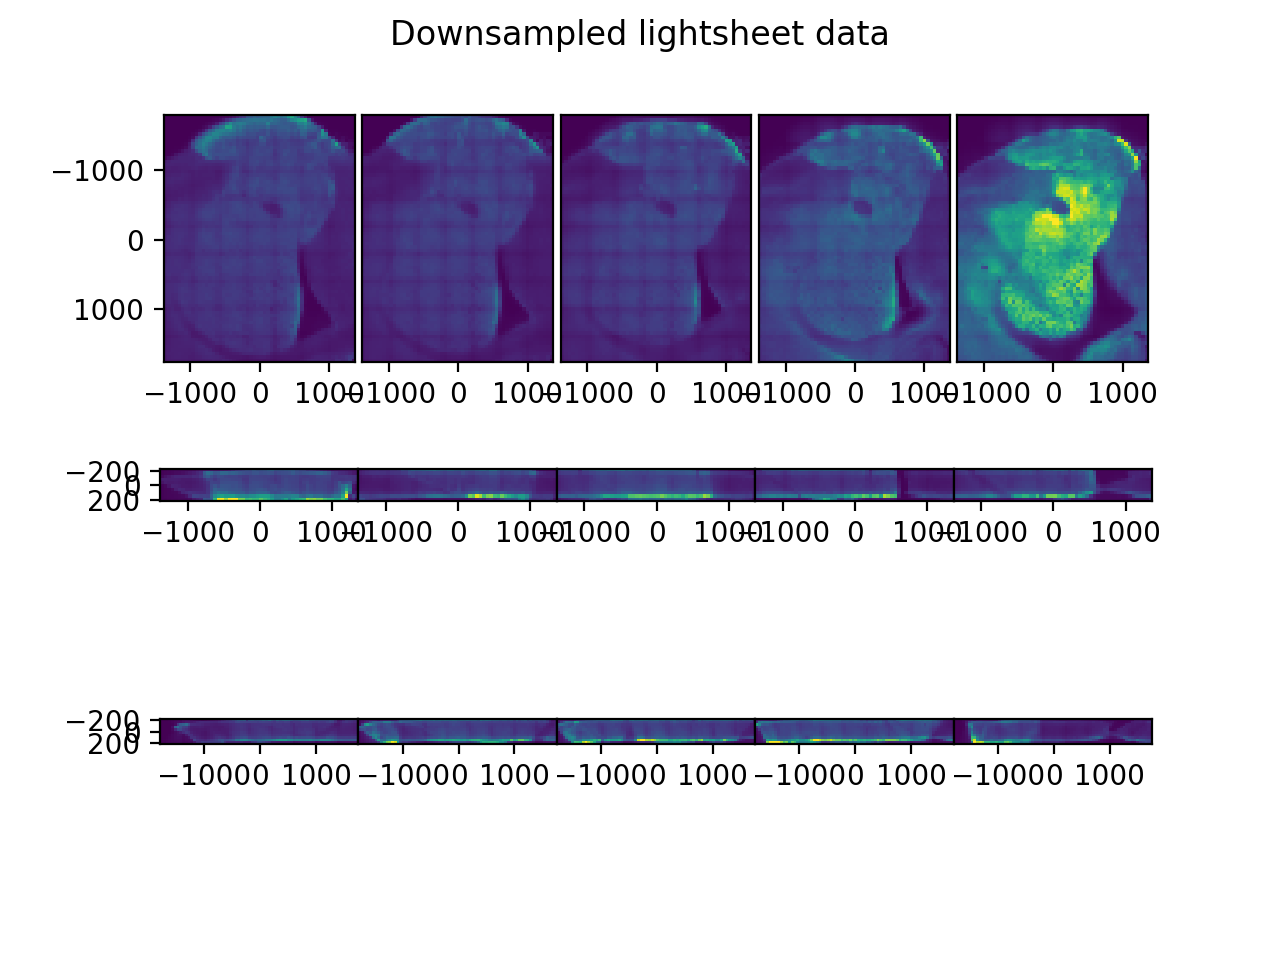

4294967296 4294967296


In [8]:
fig,ax = emlddmm.draw(J,xJ,vmin=0,vmax=1)
fig.suptitle('Downsampled lightsheet data')
figopts = {'dpi':300,'quality':90}
fig.savefig(output_prefix + 'downsampled.jpg',**figopts)

In [9]:
# load atlas images
atlas_names = [
    '/home/dtward/bmaphome/data/dong/dragonfly_03_2022/Camk2a-MORF3-D1Tom_TME07-1_10x_02_channel_1_down.npz'    
]

In [10]:
I = []
for atlas_name in atlas_names:
    atlas_data = np.load(atlas_name,allow_pickle=True)
    xI = atlas_data['xI']
    I_ = atlas_data['I'].astype(np.float32)    
    I_ -= np.quantile(I_[atlas_data['W']>0.9],0.001)
    I_ /= np.quantile(I_[atlas_data['W']>0.9],0.999)
    I_[atlas_data['W']<=0.9] = 0.0
    I.append(I_)
I = np.concatenate(I)    
if I.ndim == 3:
    I = I[None]
dI = [x[1] - x[0] for x in xI]
XI = np.meshgrid(*xI,indexing='ij')

<IPython.core.display.Javascript object>


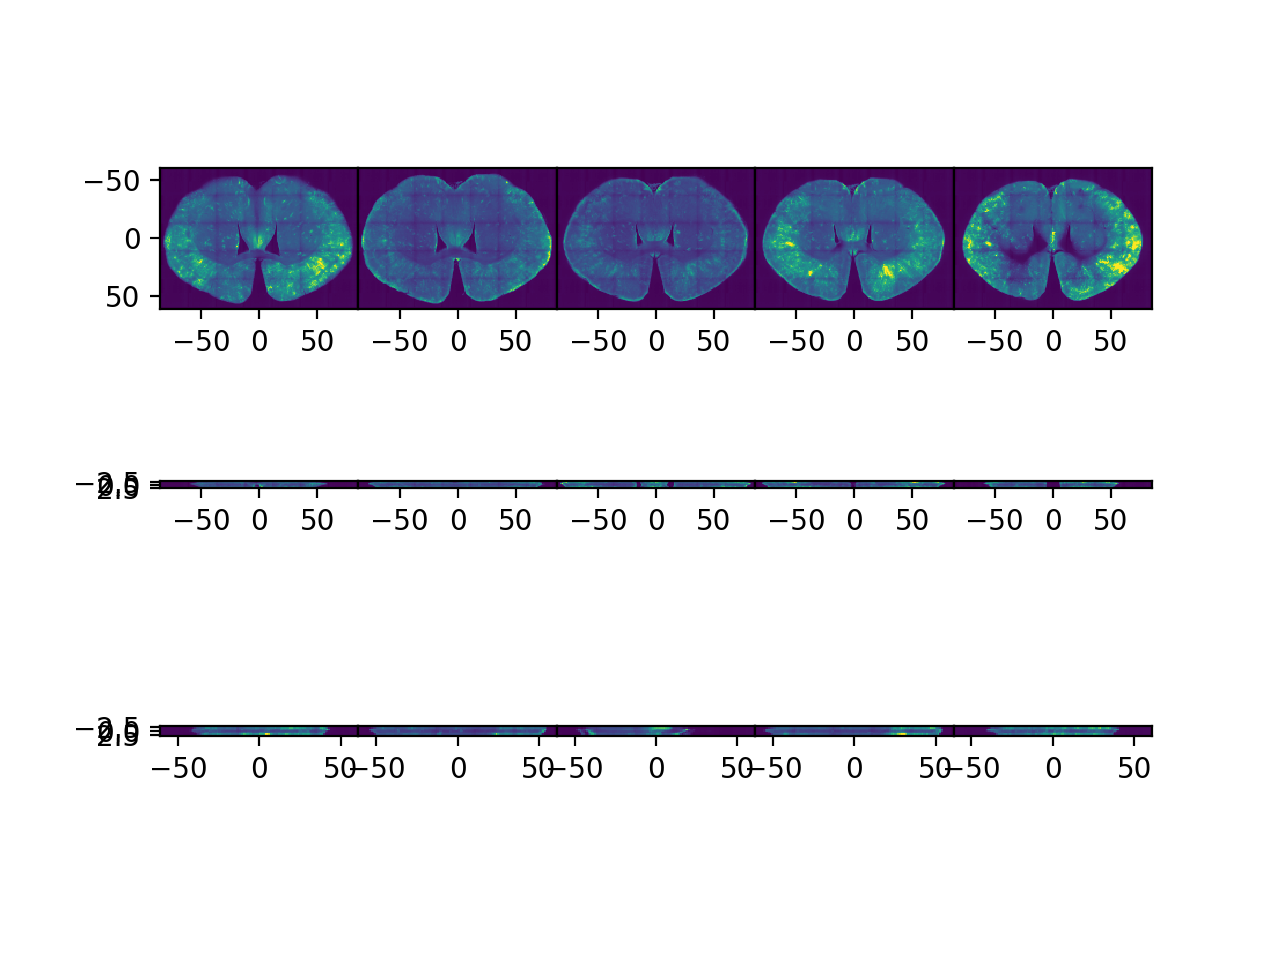

In [11]:
fig,ax = emlddmm.draw(I,vmin=0,vmax=1)
fig.canvas.draw()

# Initial preprocessing



## Target preprocessing

<IPython.core.display.Javascript object>


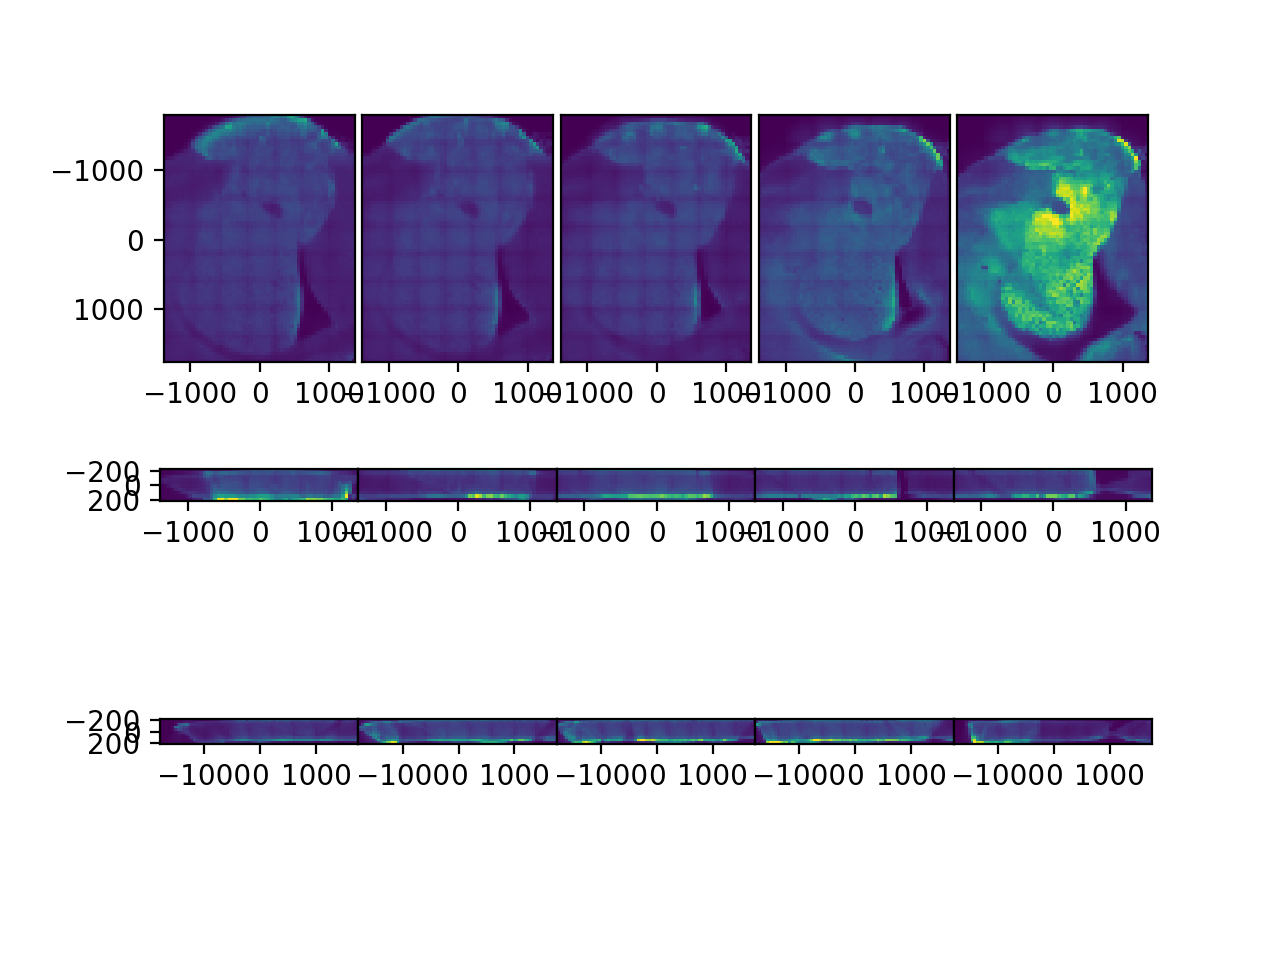

<IPython.core.display.Javascript object>


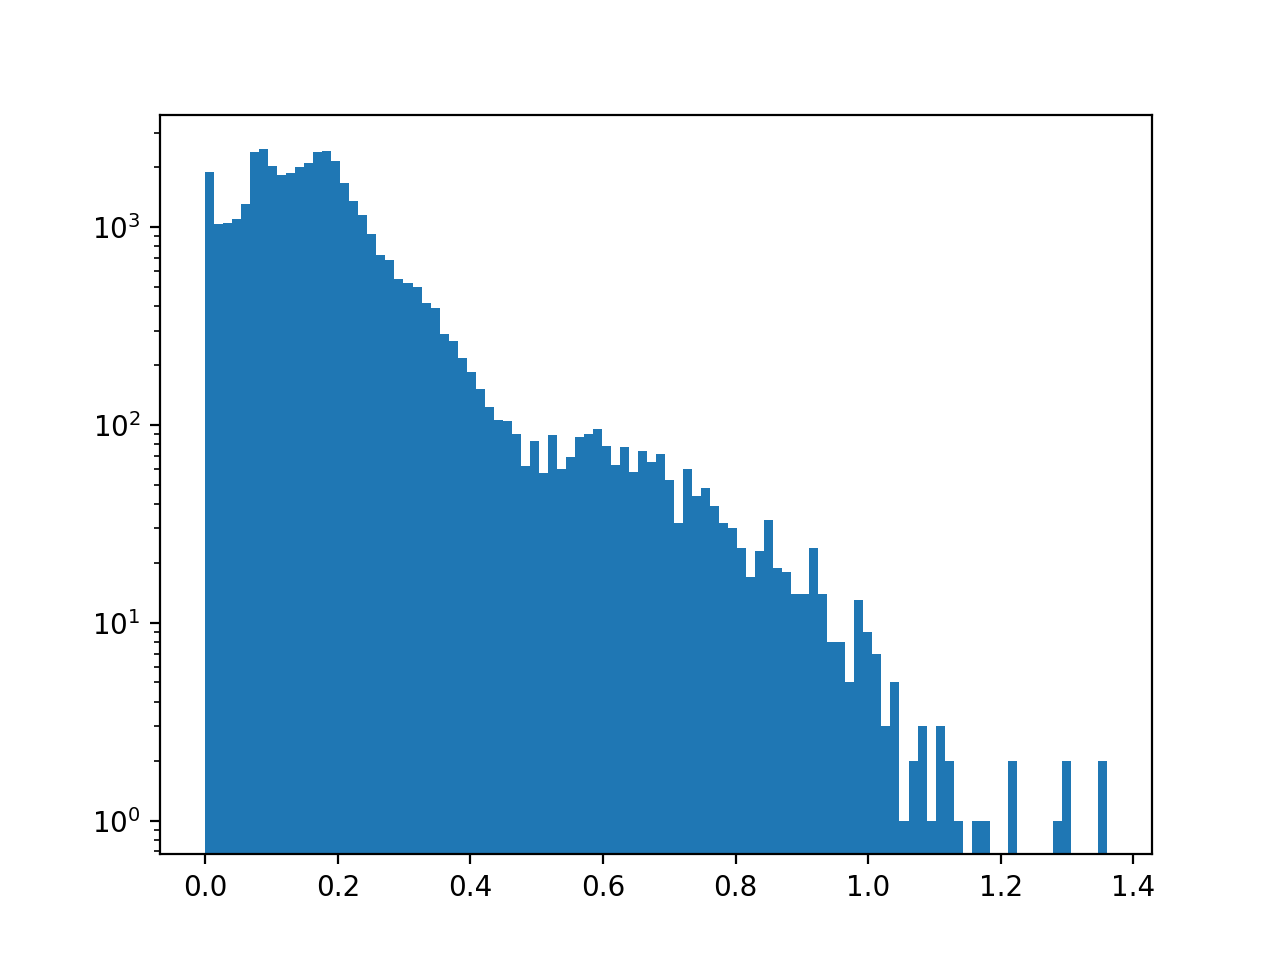

In [12]:
# adjust dynamic range
#J[J<0]=0
#J = J**0.5
# adjust mean value
#J /= np.mean(np.abs(J))
fig,ax = emlddmm.draw(J,xJ,vmin=0,vmax=1)
fig.canvas.draw()
fig,ax = plt.subplots()
ax.hist(J.ravel(),100,log=True)
fig.canvas.draw()

## Atlas preprocessing


In [13]:
# pad
# since I will downsample by 4, I want to pad with 4x4x4
npad = 4
I = np.pad(I,  ((0,0),(npad,npad),(npad,npad),(npad,npad)) )
for i in range(npad):
    xI = [ np.concatenate(   (x[0][None]-d,x,x[-1][None]+d)   ) for d,x in zip(dI,xI)]


<IPython.core.display.Javascript object>


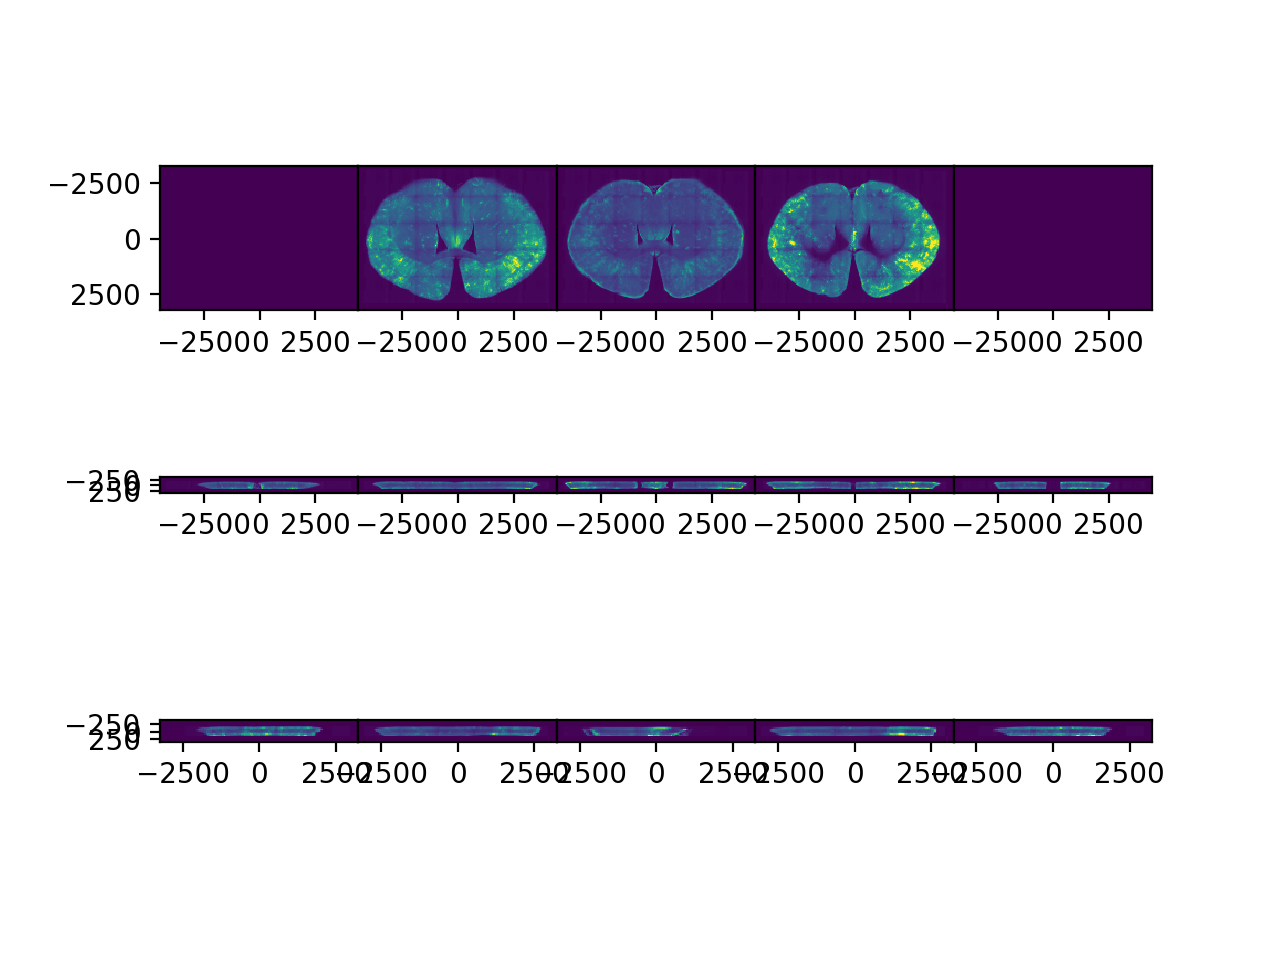

<IPython.core.display.Javascript object>


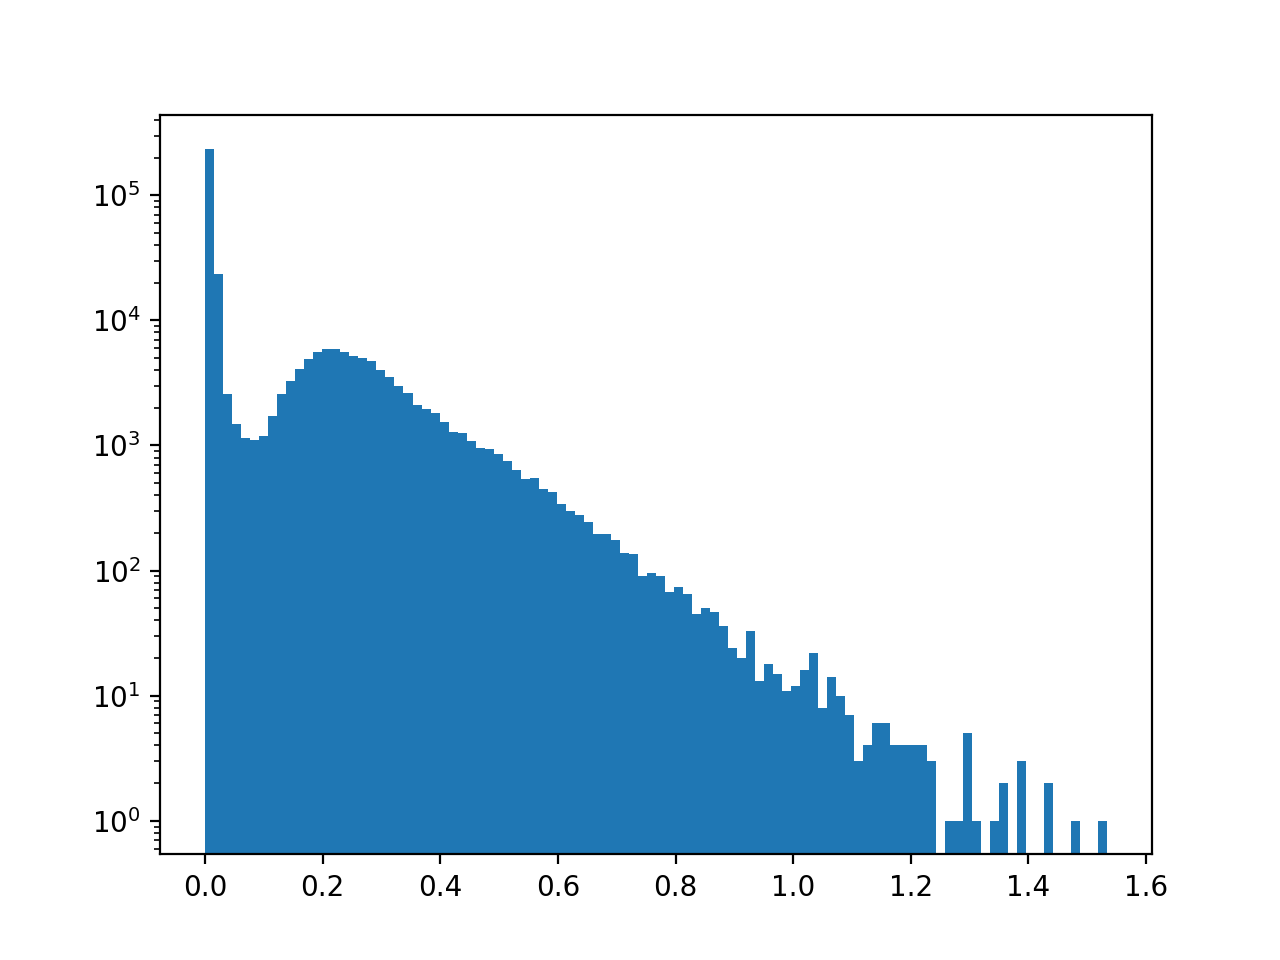

In [14]:
# adjust dynamic range
I[I<0]=0
#I = I**0.5
# adjust mean value
#J /= np.mean(np.abs(J))
fig,ax = emlddmm.draw(I,xI,vmin=0,vmax=1)
fig.canvas.draw()
fig,ax = plt.subplots()
ax.hist(I.ravel(),100,log=True)
fig.canvas.draw()

# Registration

<IPython.core.display.Javascript object>


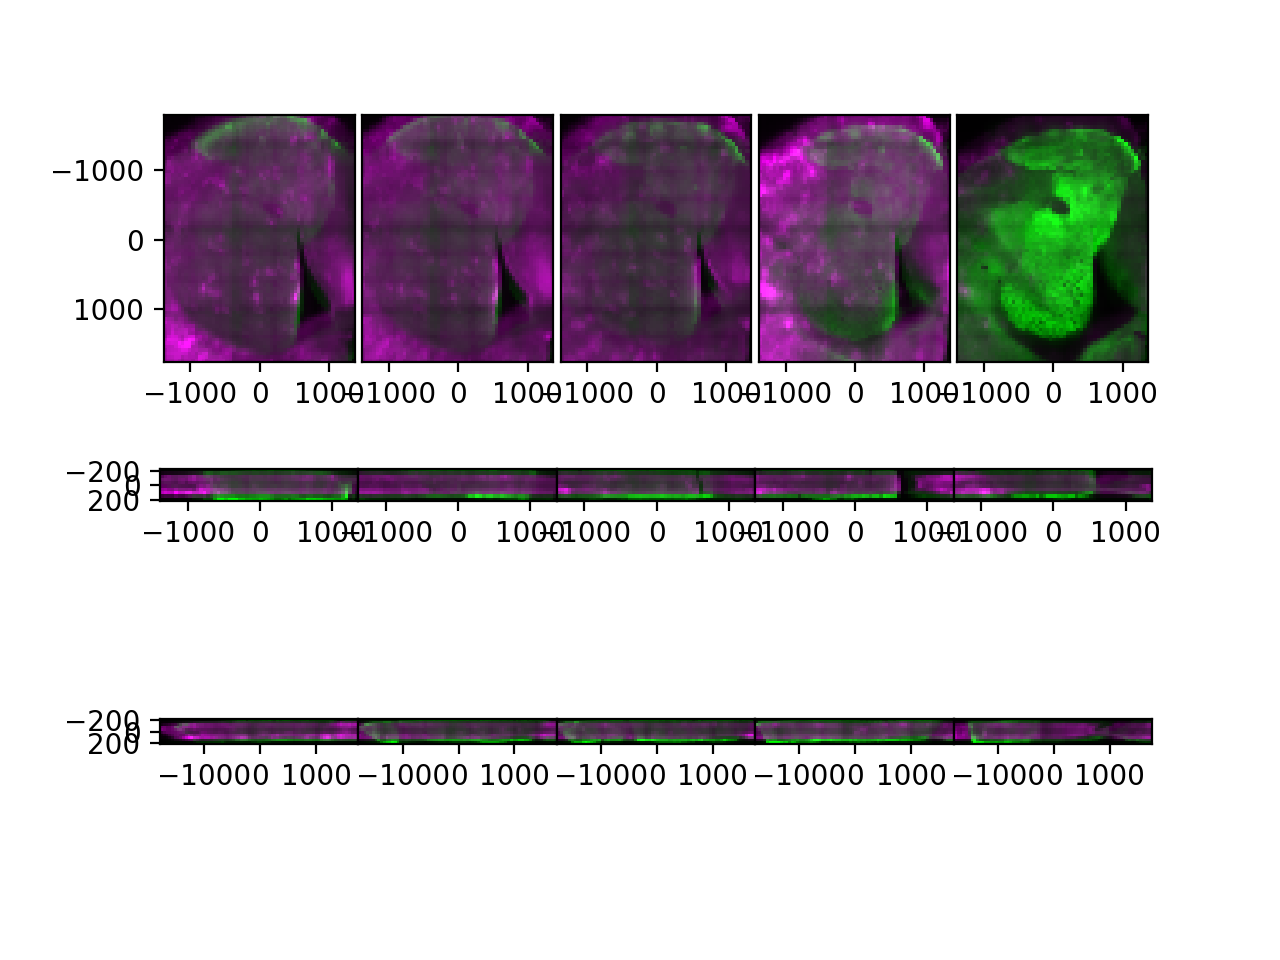

In [43]:
# initial affine
# make sure to keep sign of Jacobian
A0 = np.eye(4)
A0[0,-1] = 0.0
A0[1,-1] = 500.0
A0[2,-1] = 1500.0

# check it
XJ = np.meshgrid(*xJ,indexing='ij')
tform = emlddmm.Transform(A0,direction='b')
A0I = emlddmm.apply_transform_float(xI,I,tform.apply(XJ))
fig,ax = emlddmm.draw(np.concatenate((A0I,J)),xJ,vmin=0)
fig.canvas.draw()


dv tensor([100.0000,  99.6001,  99.6006])
a scale is 200.0


<IPython.core.display.Javascript object>


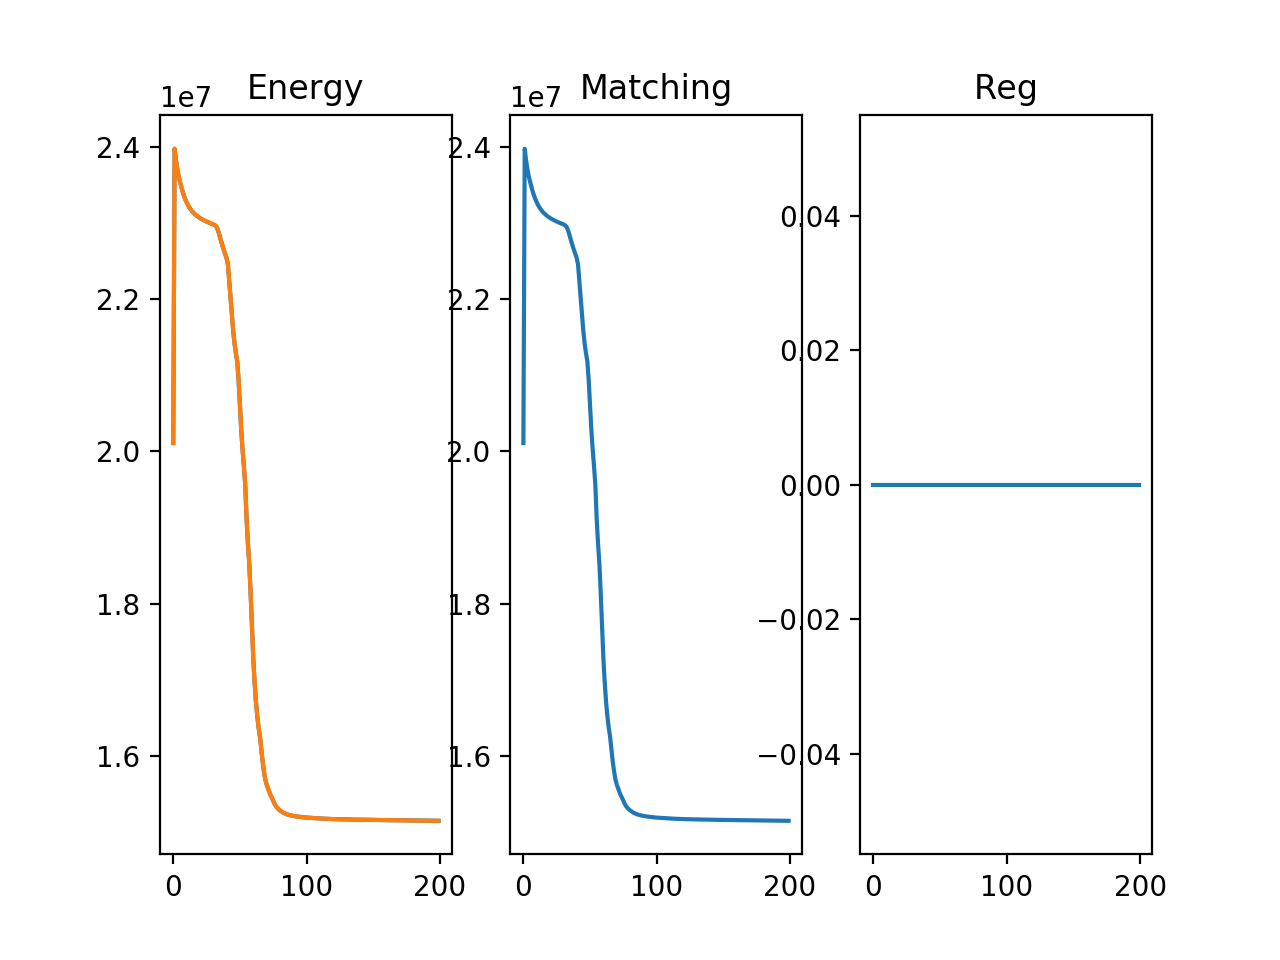

<IPython.core.display.Javascript object>


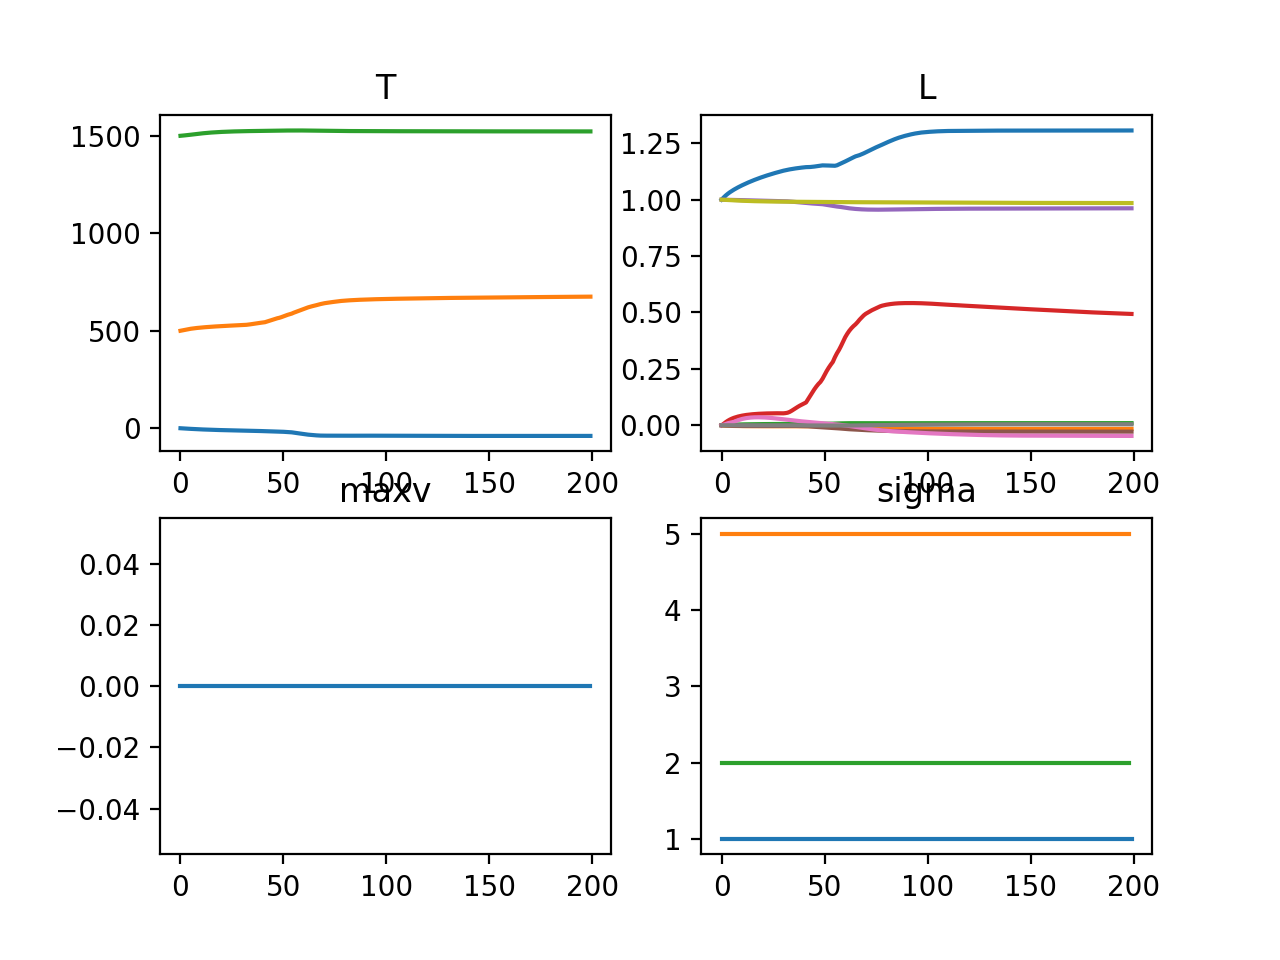

<IPython.core.display.Javascript object>


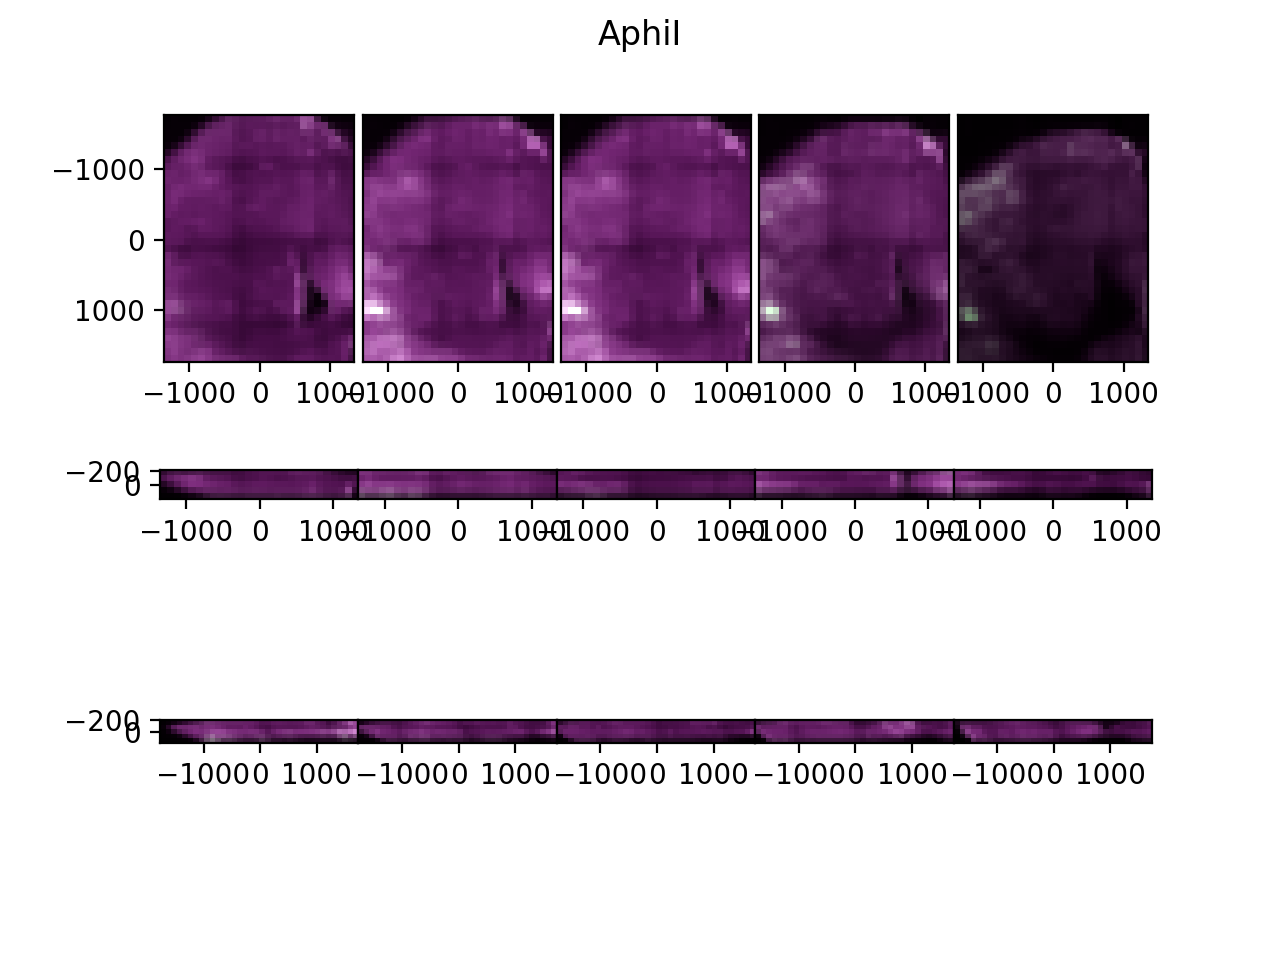

<IPython.core.display.Javascript object>


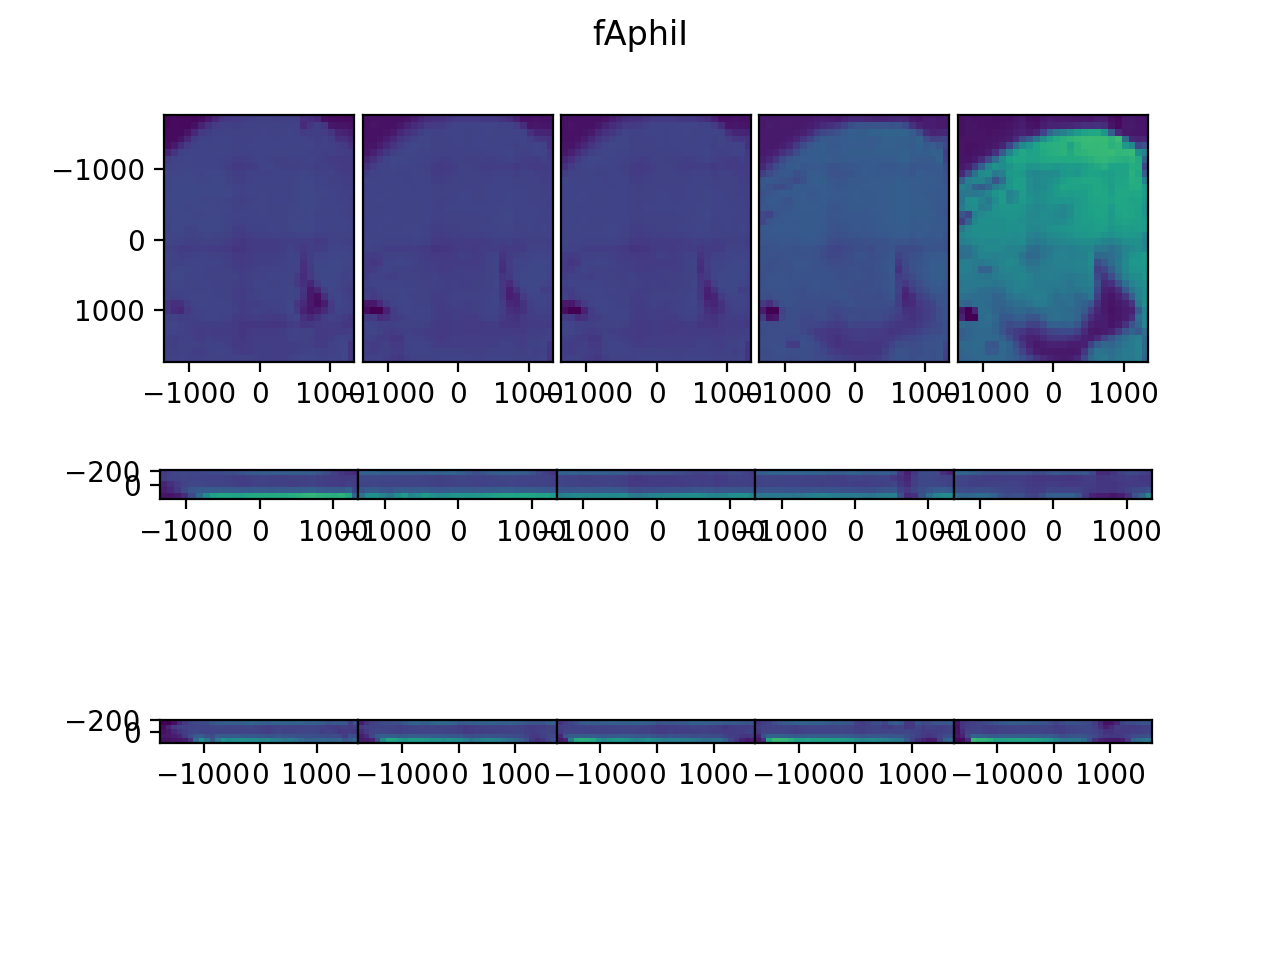

<IPython.core.display.Javascript object>


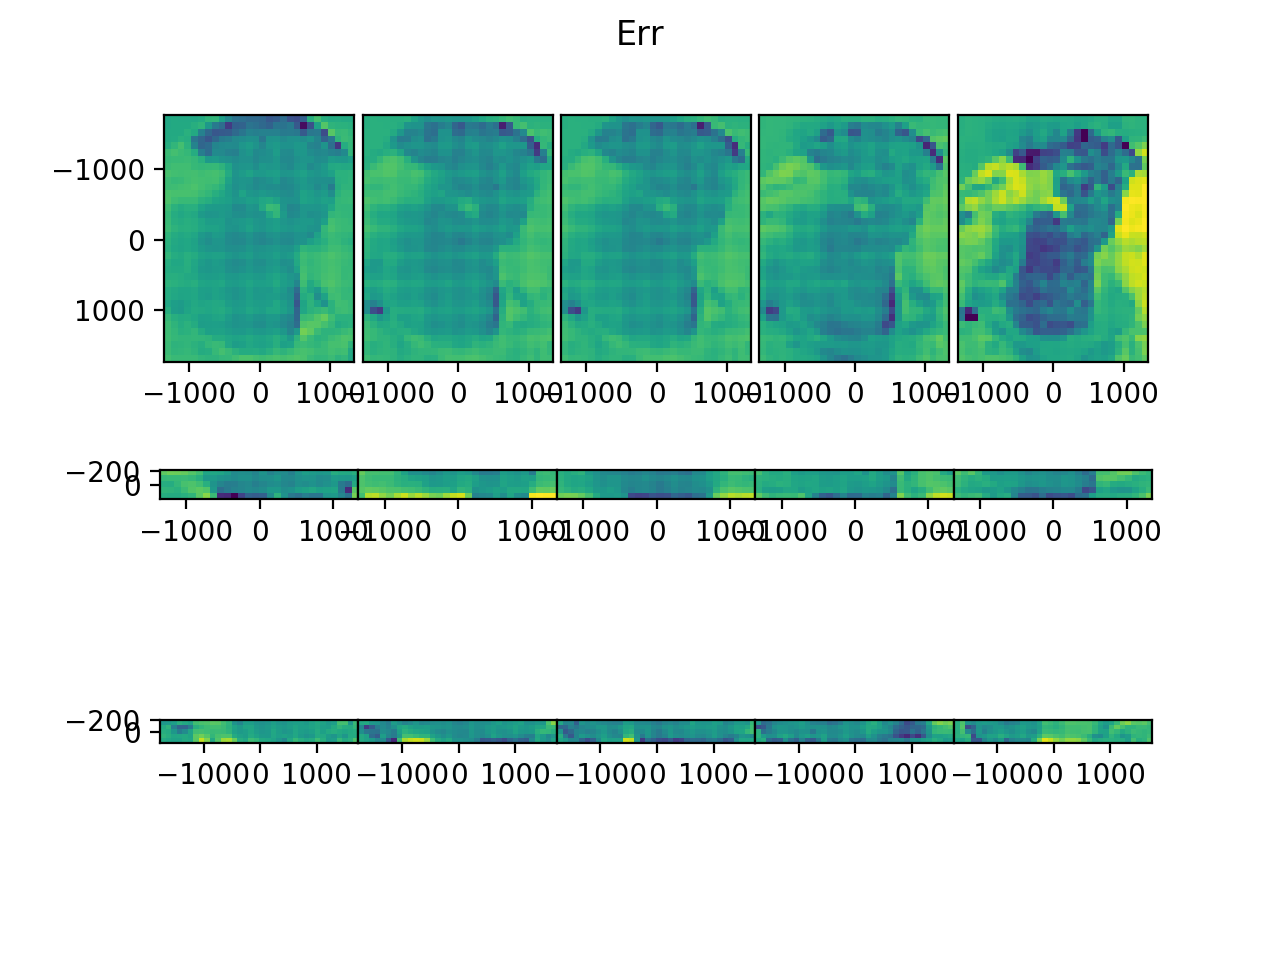

<IPython.core.display.Javascript object>


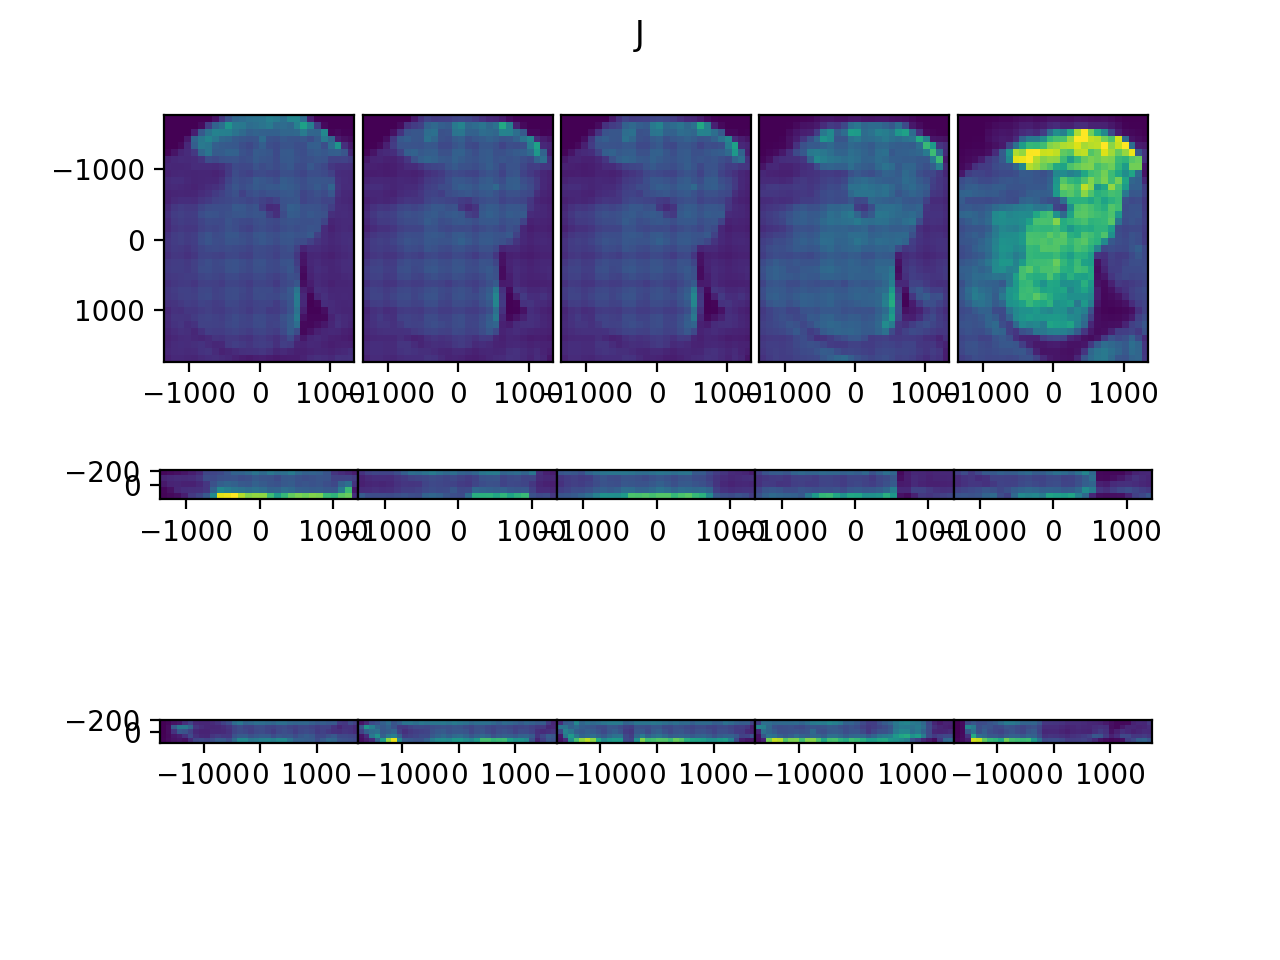

<IPython.core.display.Javascript object>


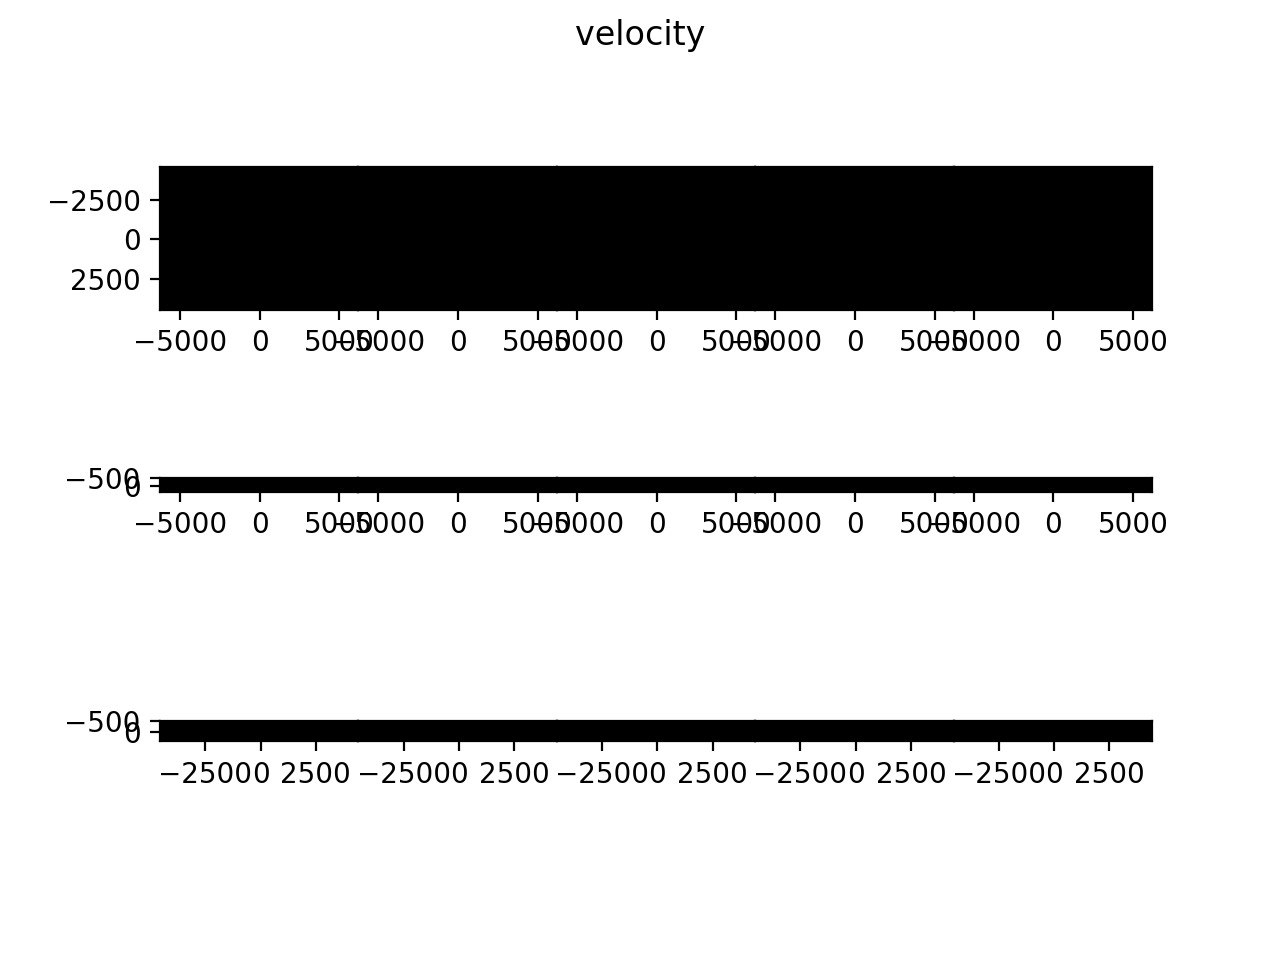

<IPython.core.display.Javascript object>


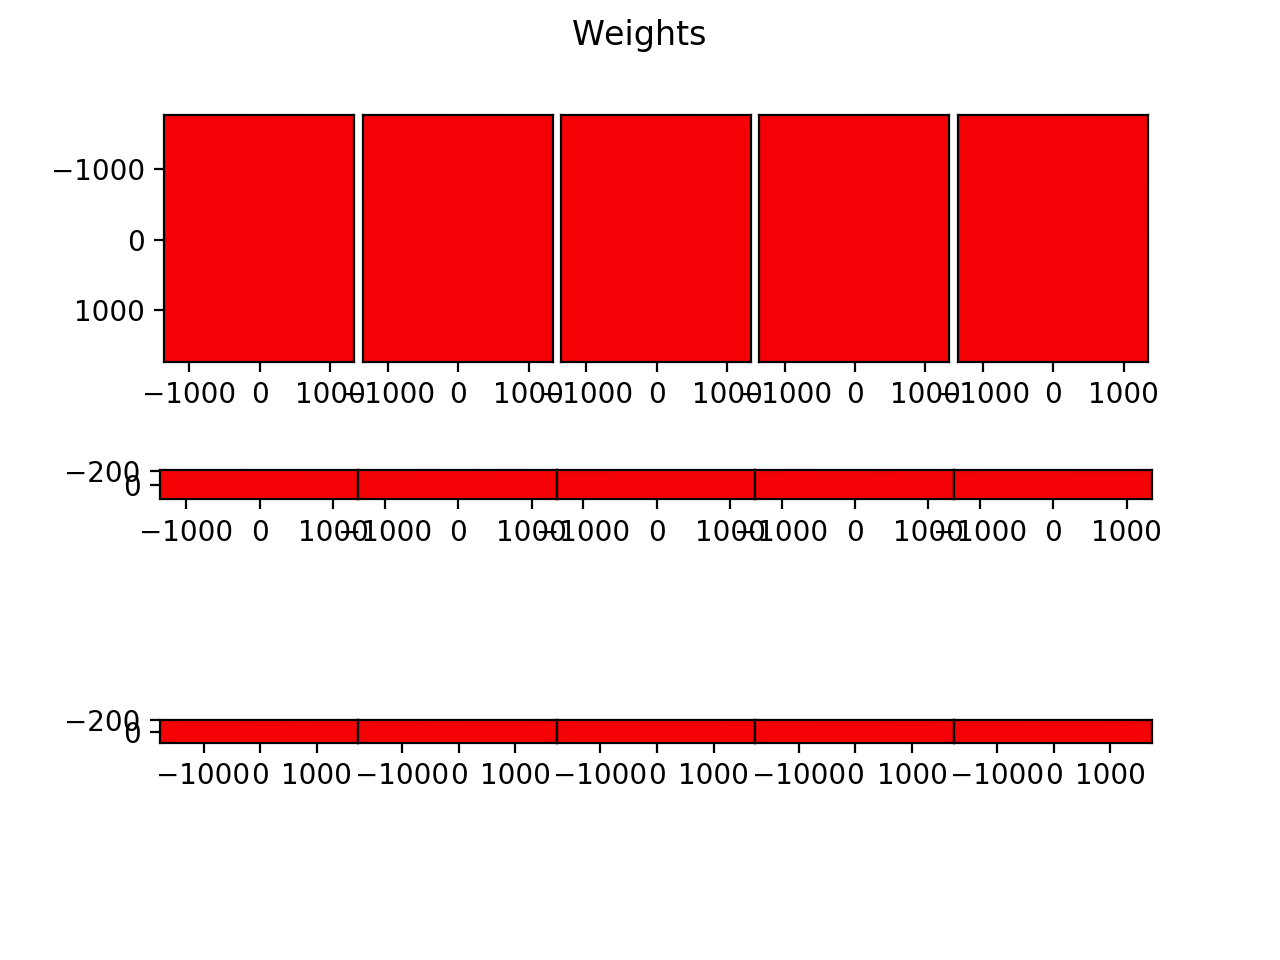

Finished iteration 0
Finished iteration 10
Finished iteration 20
Iteration 30, linear oscilating, reducing eA to 4500000.0
Finished iteration 30
Finished iteration 40
Finished iteration 50
Iteration 60, linear oscilating, reducing eA to 4050000.0
Finished iteration 60
Finished iteration 70
Finished iteration 80
Finished iteration 90
Finished iteration 100
Finished iteration 110
Iteration 120, translation oscilating, reducing eA to 3645000.0
Finished iteration 120
Finished iteration 130
Finished iteration 140
Iteration 150, translation oscilating, reducing eA to 3280500.0
Finished iteration 150
Finished iteration 160
Iteration 170, translation oscilating, reducing eA to 2952450.0
Finished iteration 170
Iteration 180, linear oscilating, reducing eA to 2657205.0
Finished iteration 180
Iteration 190, translation oscilating, reducing eA to 2391484.5
Finished iteration 190


In [19]:
# now we want to register
# we'll start with an affine registration
import imp
imp.reload(emlddmm)
config0 = {
    'device':'cpu',
    'n_iter':200, 'downI':[2,2,2], 'downJ':[2,2,2],
     'priors':[0.9,0.05,0.05],'update_priors':False,
     'update_muA':0,'muA':[np.quantile(J,0.99)],
     'update_muB':0,'muB':[0.0],     
     'sigmaM':1.0,'sigmaB':2.0,'sigmaA':5.0,
     'order':1,'n_draw':50,'n_estep':3,'slice_matching':0,'v_start':1000,
     'eA':5e6,'A':A0,'full_outputs':True,'local_contrast':[1,100,100]
   }




I_ = np.concatenate((I,I**2))
out = emlddmm.emlddmm(xI=xI,I=I_,xJ=xJ,J=J, W0=target_data['W'], **config0)

In [25]:
config1

{'device': 'cpu',
 'n_iter': 2000,
 'downI': [2, 2, 2],
 'downJ': [2, 2, 2],
 'priors': [0.9, 0.05, 0.05],
 'update_priors': False,
 'update_muA': 0,
 'muA': [0.7552669930458062],
 'update_muB': 0,
 'muB': [0.0],
 'sigmaM': 1.0,
 'sigmaB': 2.0,
 'sigmaA': 5.0,
 'order': 1,
 'n_draw': 50,
 'n_estep': 3,
 'slice_matching': 0,
 'v_start': 0,
 'eA': 500000.0,
 'A': tensor([[ 1.3067e+00, -1.6144e-02,  9.4072e-03, -3.9342e+01],
         [ 4.9304e-01,  9.6174e-01, -2.8411e-02,  6.7504e+02],
         [-4.7345e-02,  4.3235e-03,  9.8498e-01,  1.5224e+03],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]),
 'full_outputs': True,
 'local_contrast': [1, 100, 100],
 'a': 1000.0,
 'sigmaR': 50000.0,
 'ev': 0.02,
 'v_res_factor': 10.0}

dv tensor([250.0000, 249.0002, 249.0015])
a scale is 1000.0


<IPython.core.display.Javascript object>


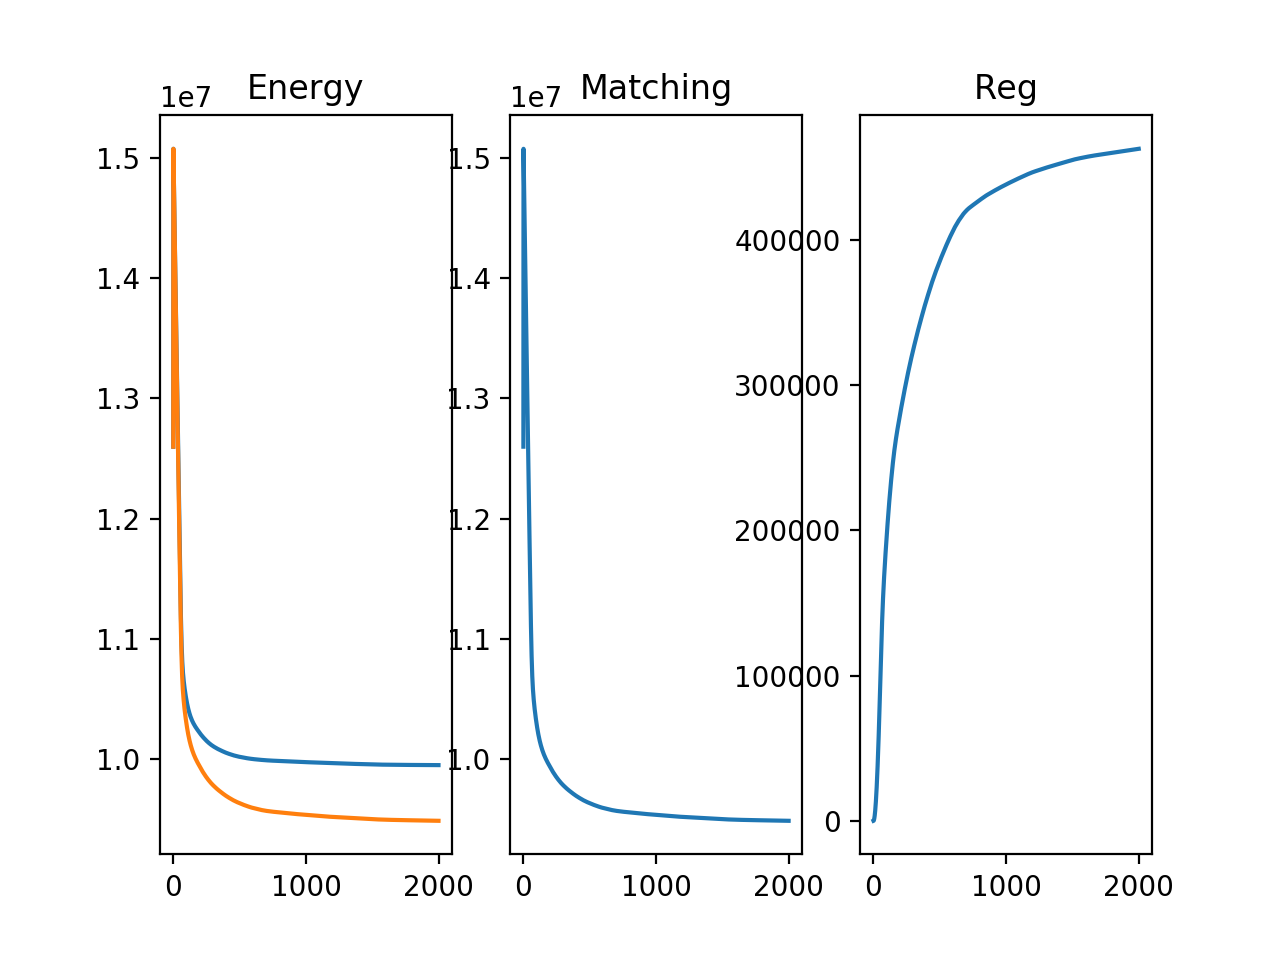

<IPython.core.display.Javascript object>


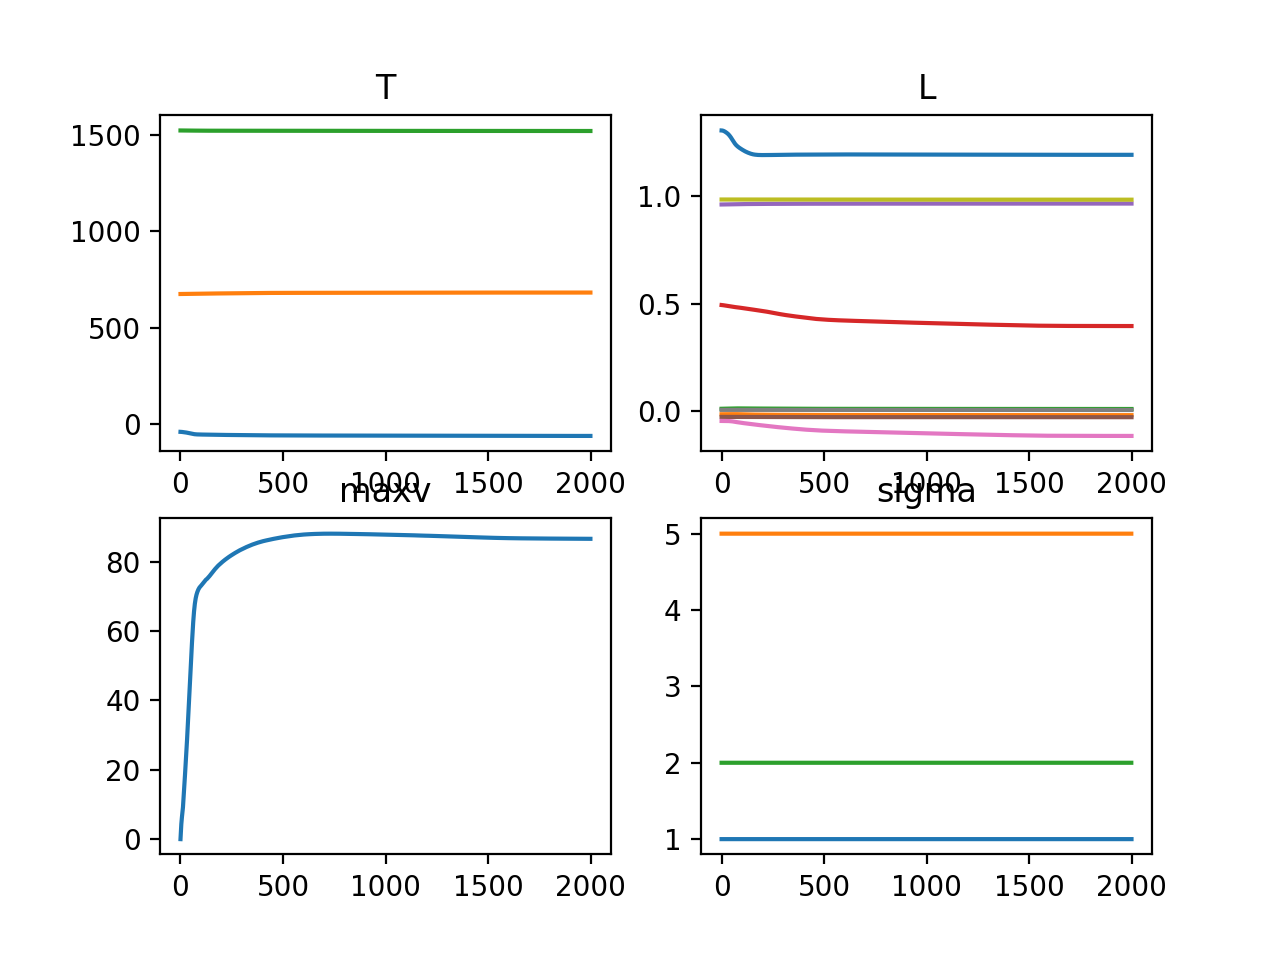

<IPython.core.display.Javascript object>


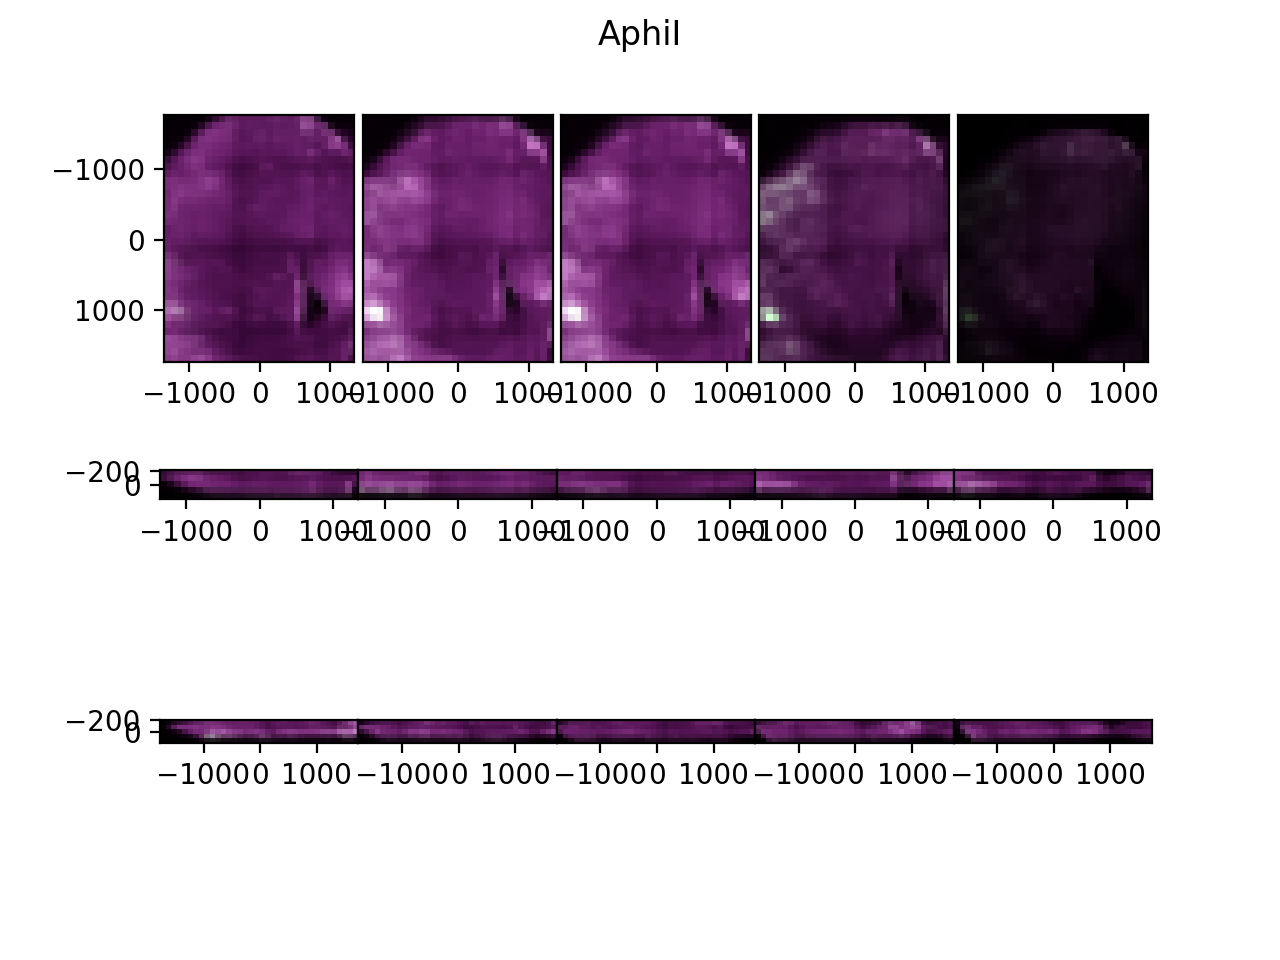

<IPython.core.display.Javascript object>


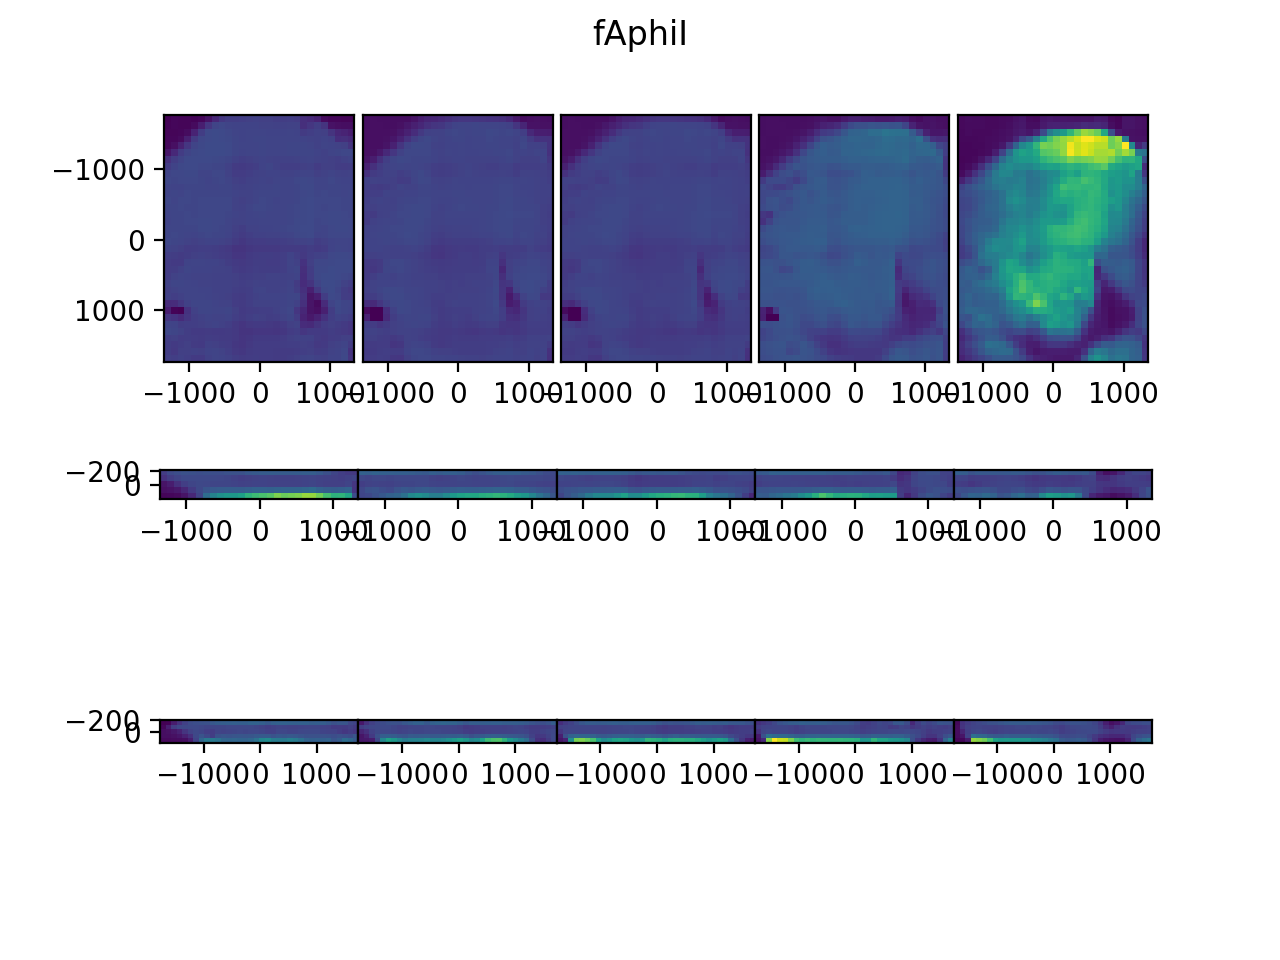

<IPython.core.display.Javascript object>


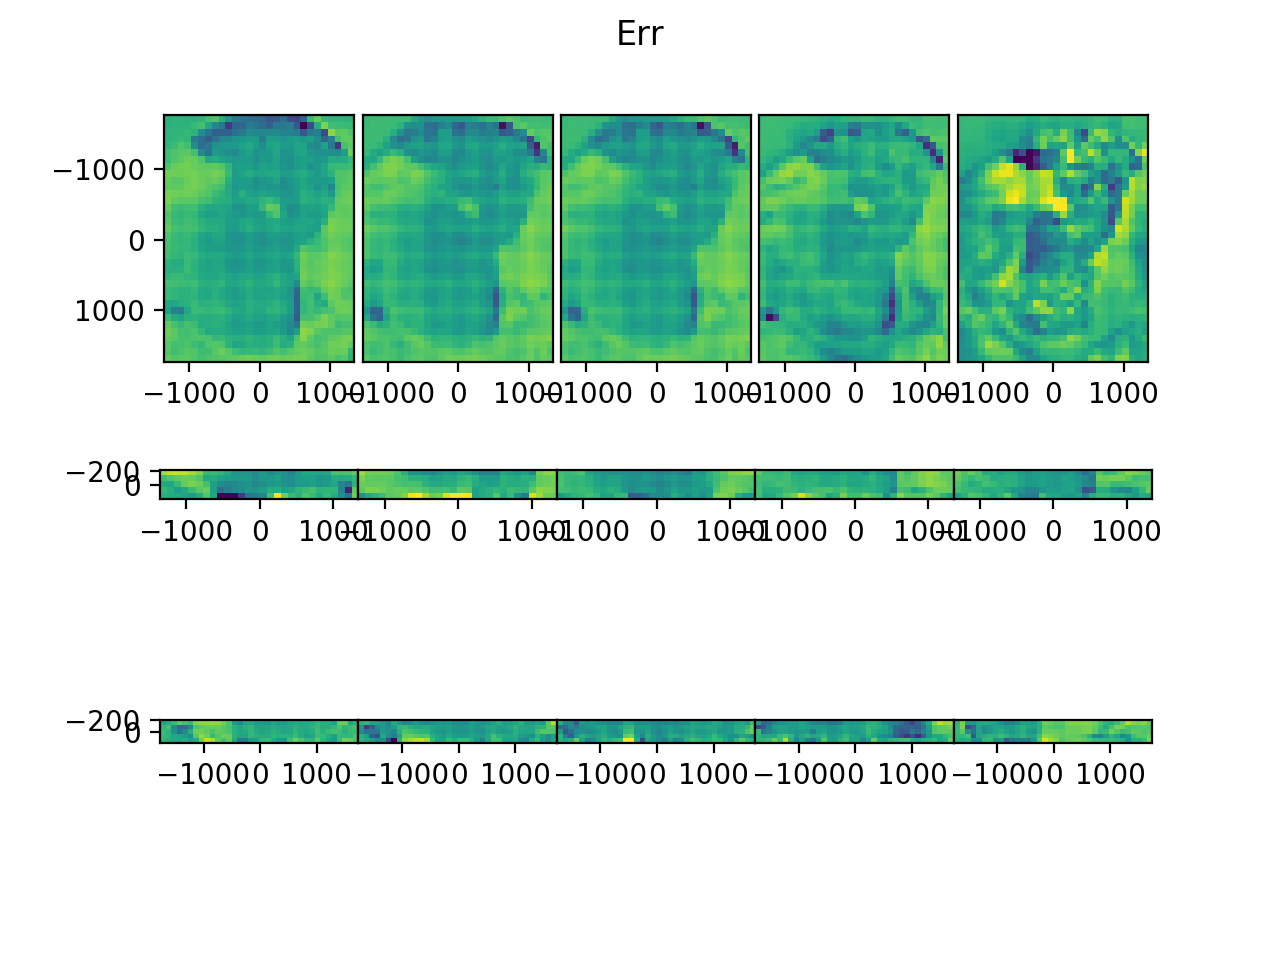

<IPython.core.display.Javascript object>


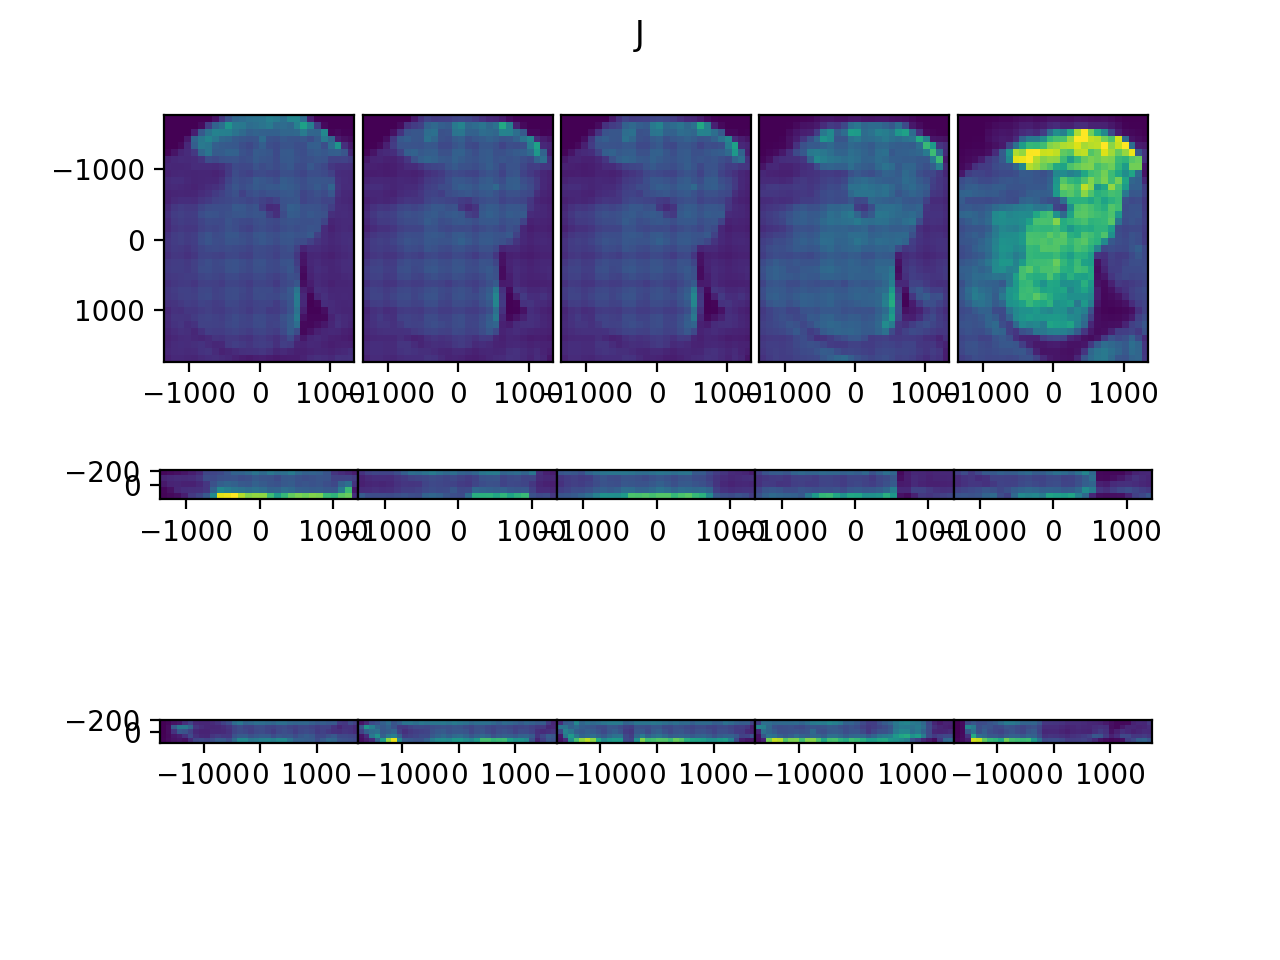

<IPython.core.display.Javascript object>


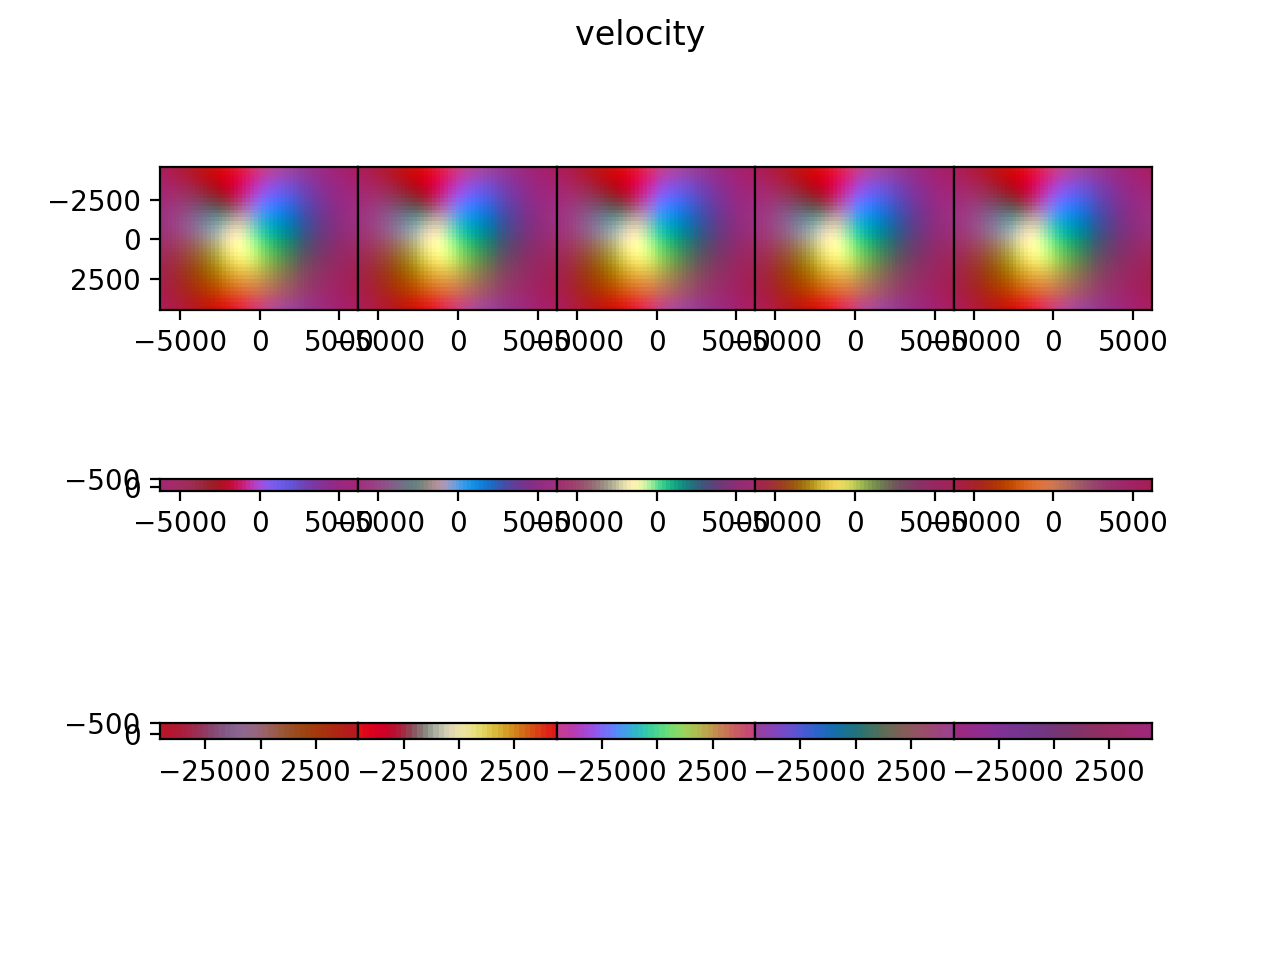

<IPython.core.display.Javascript object>


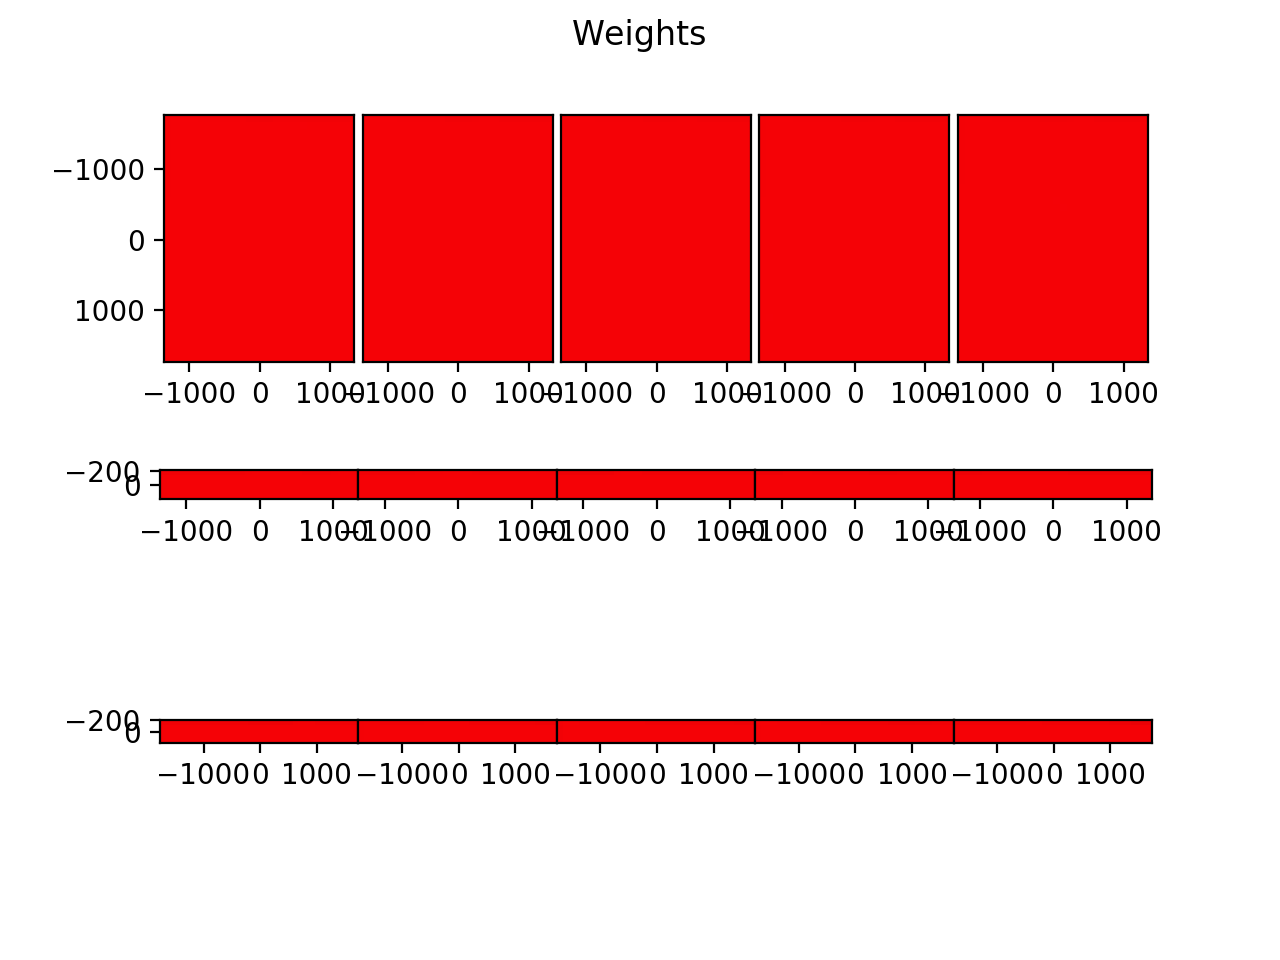

Finished iteration 0
Finished iteration 10
Finished iteration 20
Finished iteration 30
Finished iteration 40
Finished iteration 50
Finished iteration 60
Finished iteration 70
Finished iteration 80
Finished iteration 90
Finished iteration 100
Finished iteration 110
Finished iteration 120
Finished iteration 130
Finished iteration 140
Finished iteration 150
Finished iteration 160
Finished iteration 170
Finished iteration 180
Finished iteration 190
Finished iteration 200
Finished iteration 210
Finished iteration 220
Finished iteration 230
Finished iteration 240
Finished iteration 250
Finished iteration 260
Finished iteration 270
Finished iteration 280
Iteration 290, translation oscilating, reducing eA to 450000.0
Finished iteration 290
Finished iteration 300
Finished iteration 310
Finished iteration 320
Iteration 330, linear oscilating, reducing eA to 405000.0
Finished iteration 330
Finished iteration 340
Finished iteration 350
Finished iteration 360
Finished iteration 370
Finished iterati

Iteration 1890, translation oscilating, reducing eA to 4363.981784043859
Finished iteration 1890
Iteration 1900, translation oscilating, reducing eA to 3927.5836056394733
Finished iteration 1900
Finished iteration 1910
Finished iteration 1920
Finished iteration 1930
Finished iteration 1940
Finished iteration 1950
Finished iteration 1960
Finished iteration 1970
Finished iteration 1980
Finished iteration 1990


In [27]:
# second run, with deformation
imp.reload(emlddmm)
config1 = dict(config0)
config1['A'] = out['A']
config1['eA'] = config0['eA']*0.1
config1['a'] = 1000.0
config1['sigmaR'] = 5e4 # 1e4 gave really good results, but try 2e4, also good, I showed this in my slides
config1['n_iter']= 2000
config1['v_start'] = 0
config1['ev'] = 1e0
config1['v_res_factor'] = config1['a']/dI[0]/2/2 # what is the resolution of v, as a multiple of that in I

config1['device'] = 'cpu'
# changing my inverses to double did not fix the issue
#config1['device'] = 'cuda:1'




out1 = emlddmm.emlddmm(xI=xI,I=I_,xJ=xJ,J=J, W0=target_data['W'], **config1)

dv tensor([250.0000, 249.0002, 249.0015])
a scale is 1000.0


<IPython.core.display.Javascript object>


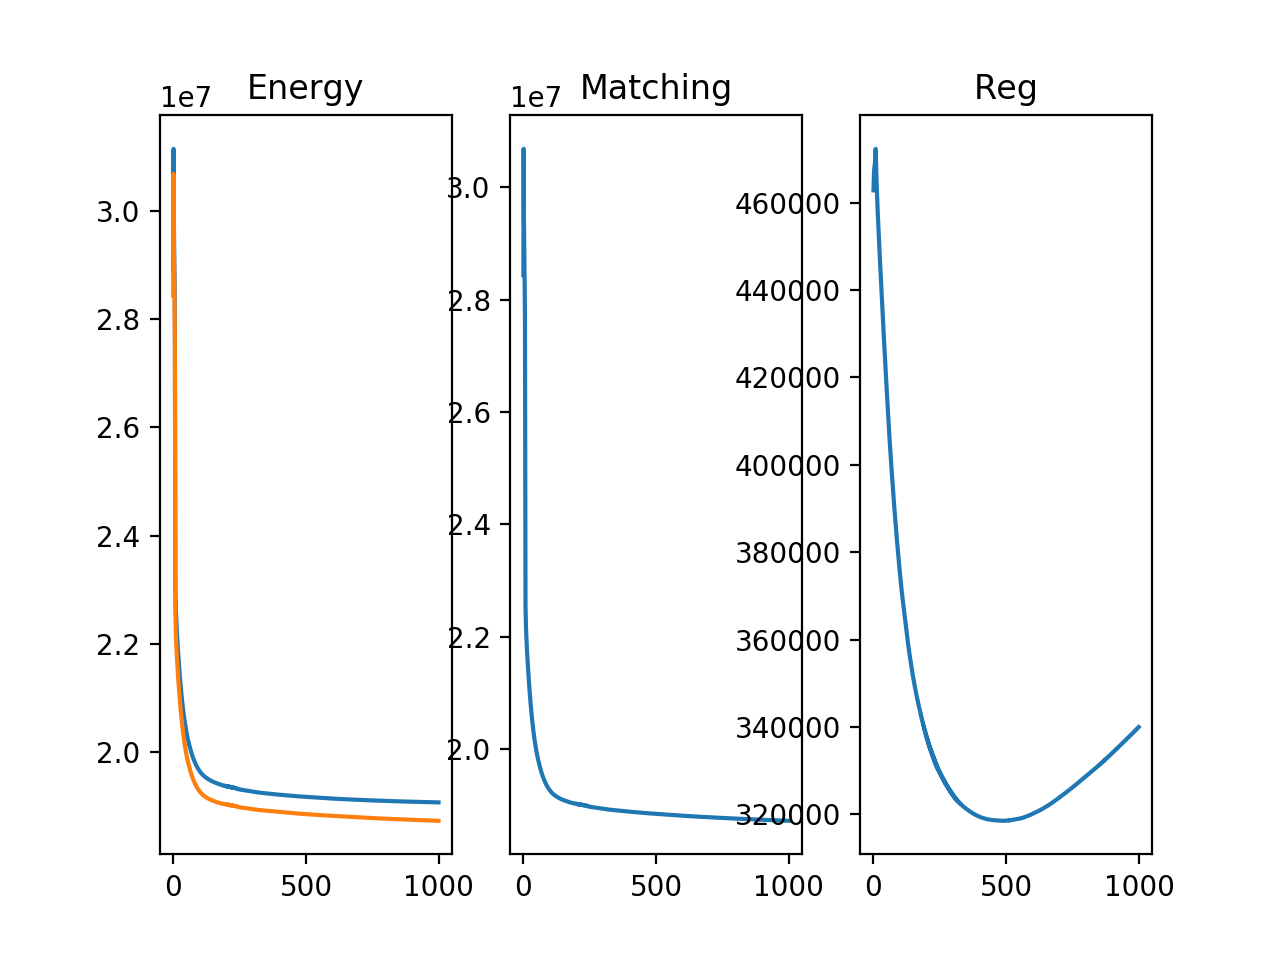

<IPython.core.display.Javascript object>


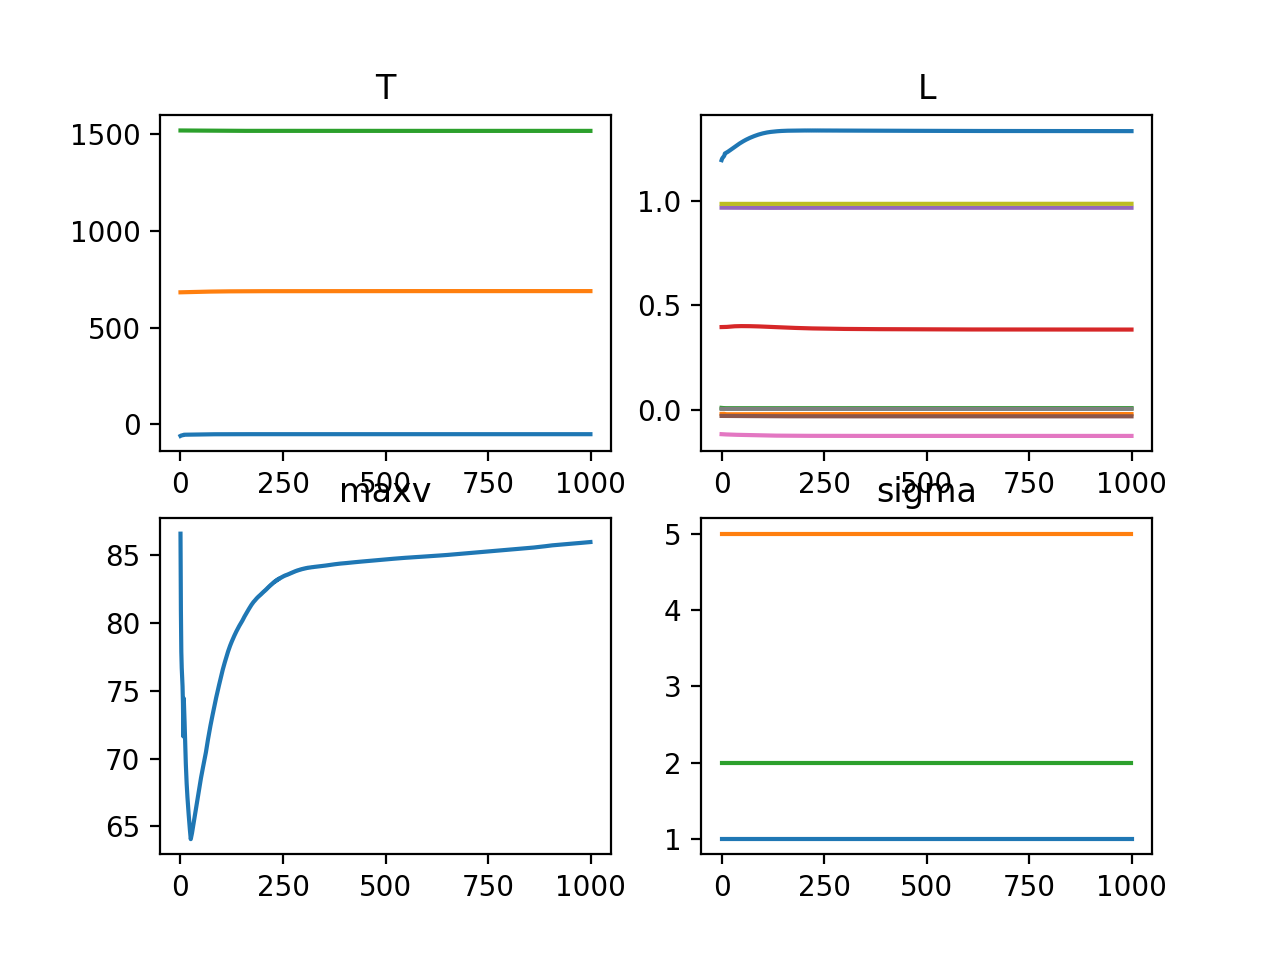

<IPython.core.display.Javascript object>


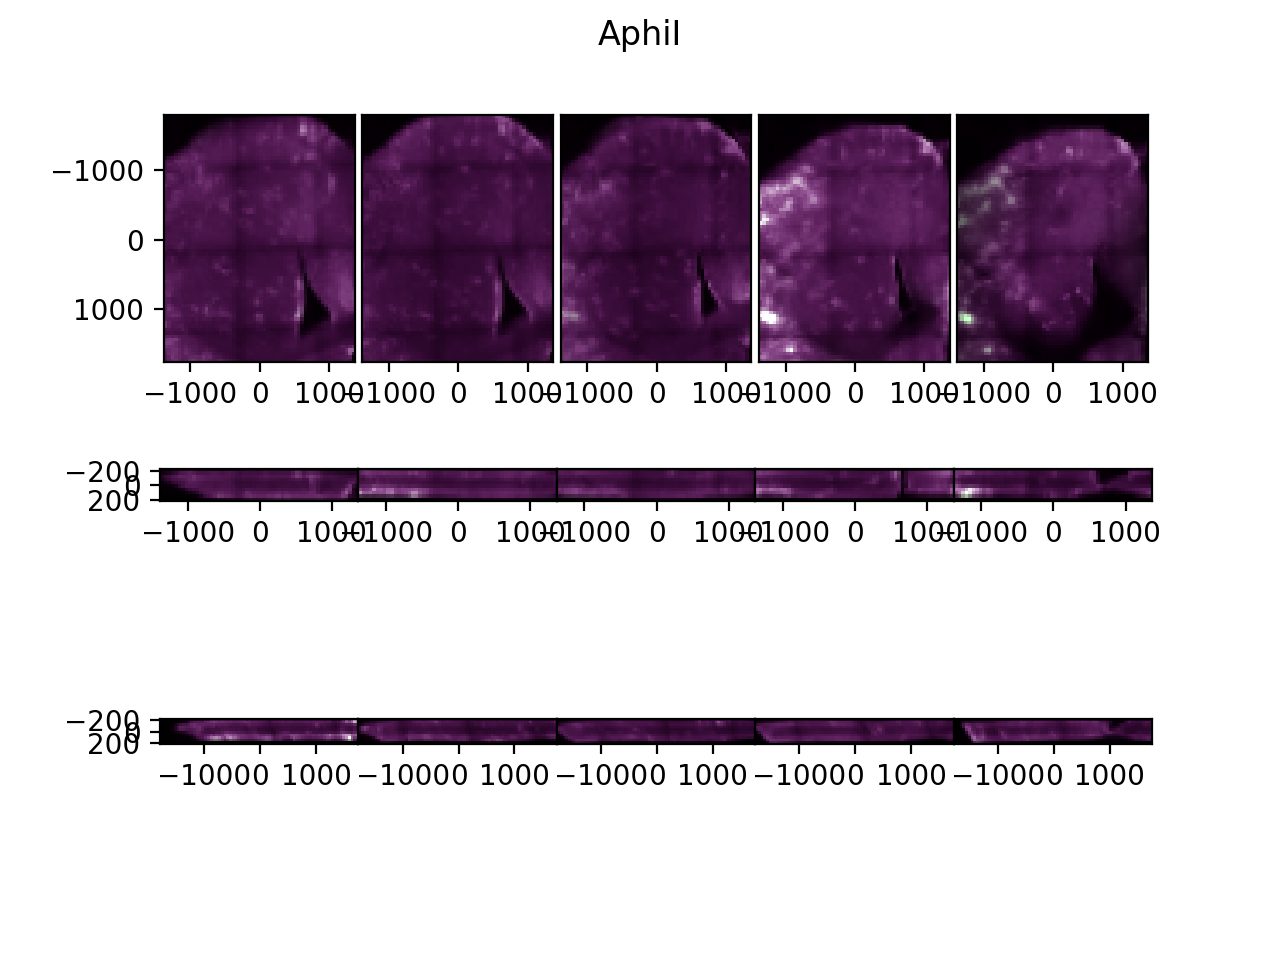

<IPython.core.display.Javascript object>


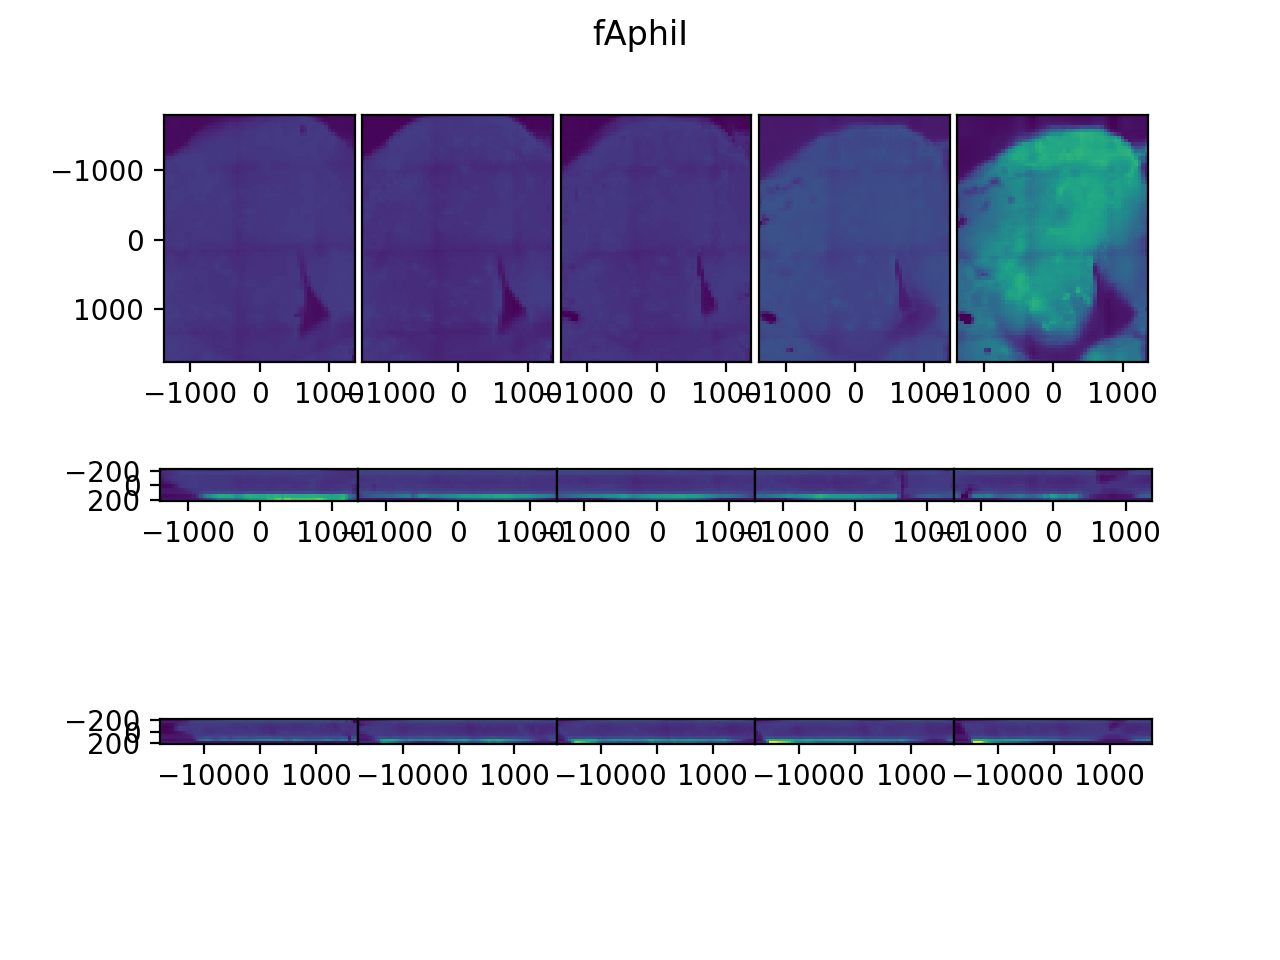

<IPython.core.display.Javascript object>


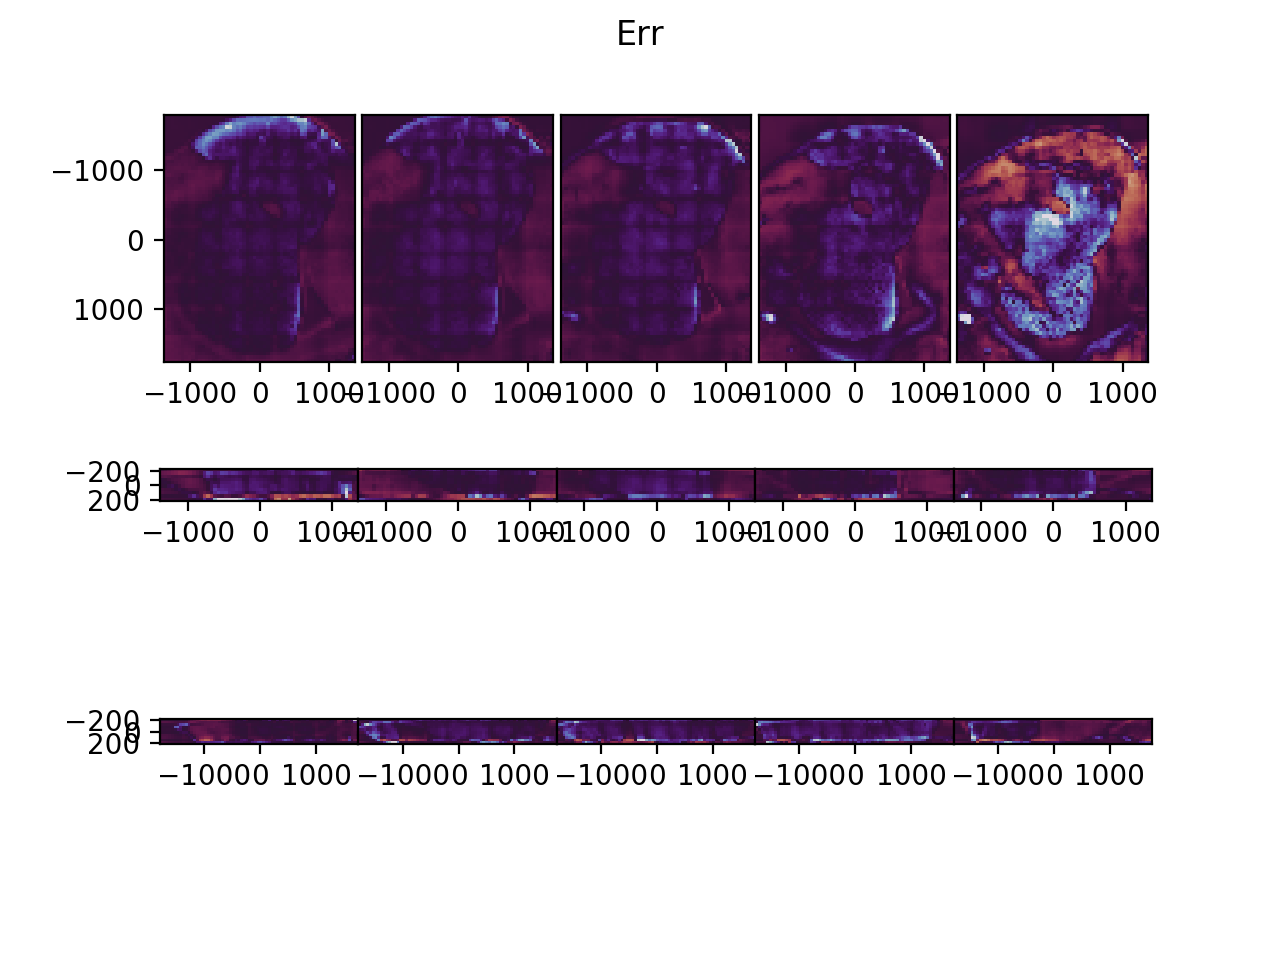

<IPython.core.display.Javascript object>


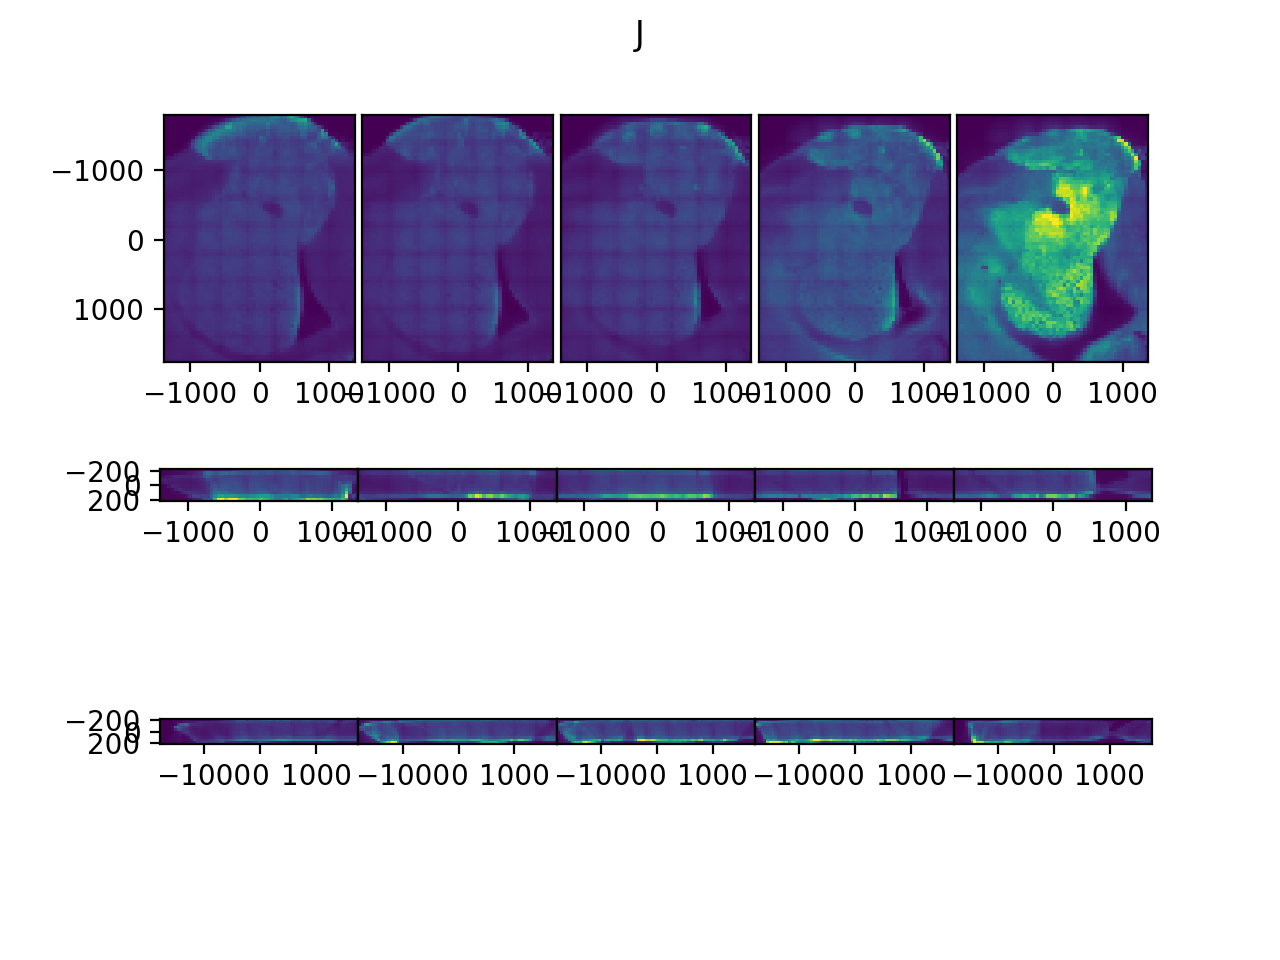

<IPython.core.display.Javascript object>


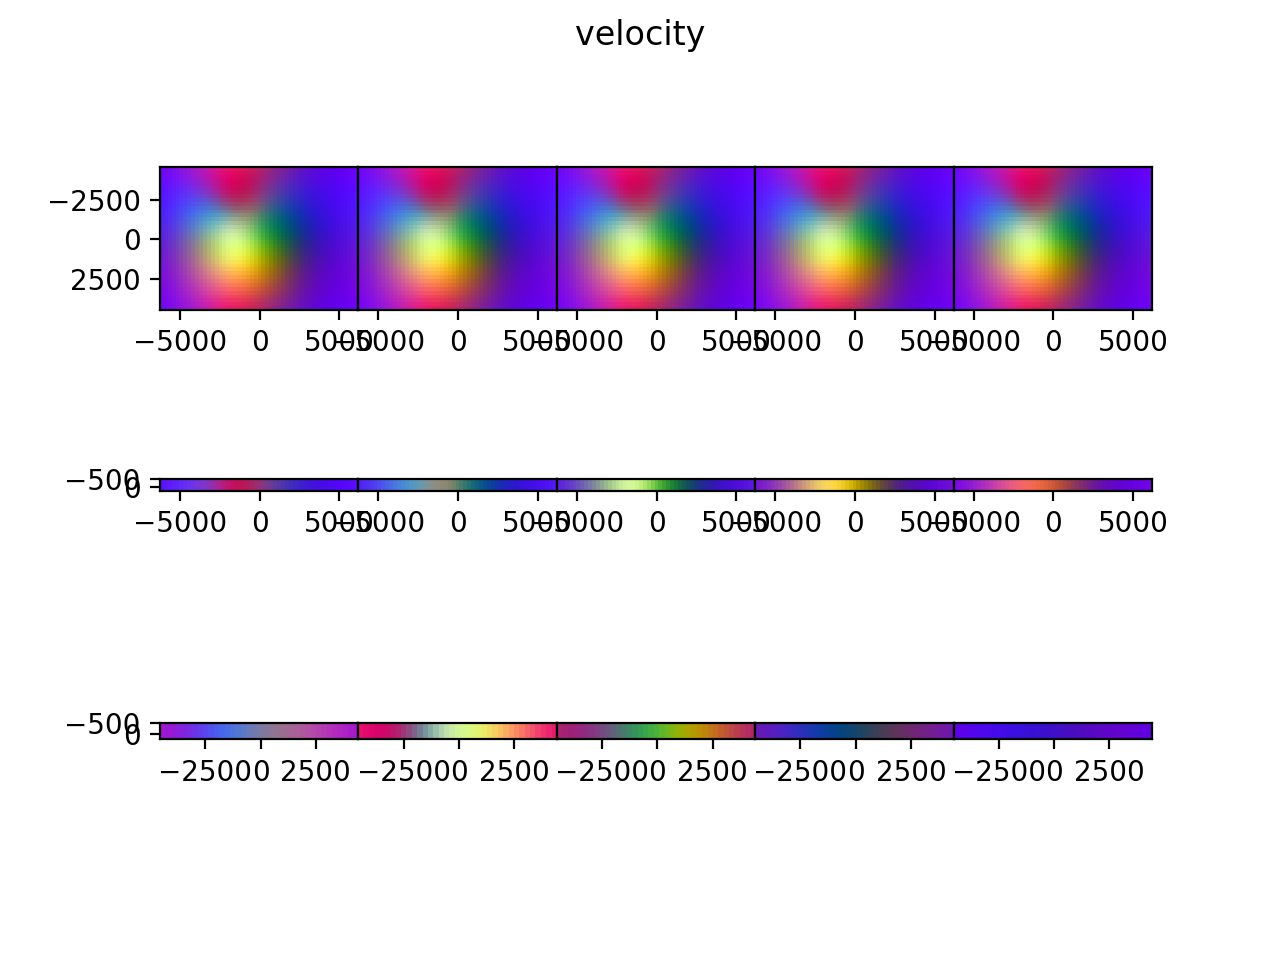

<IPython.core.display.Javascript object>


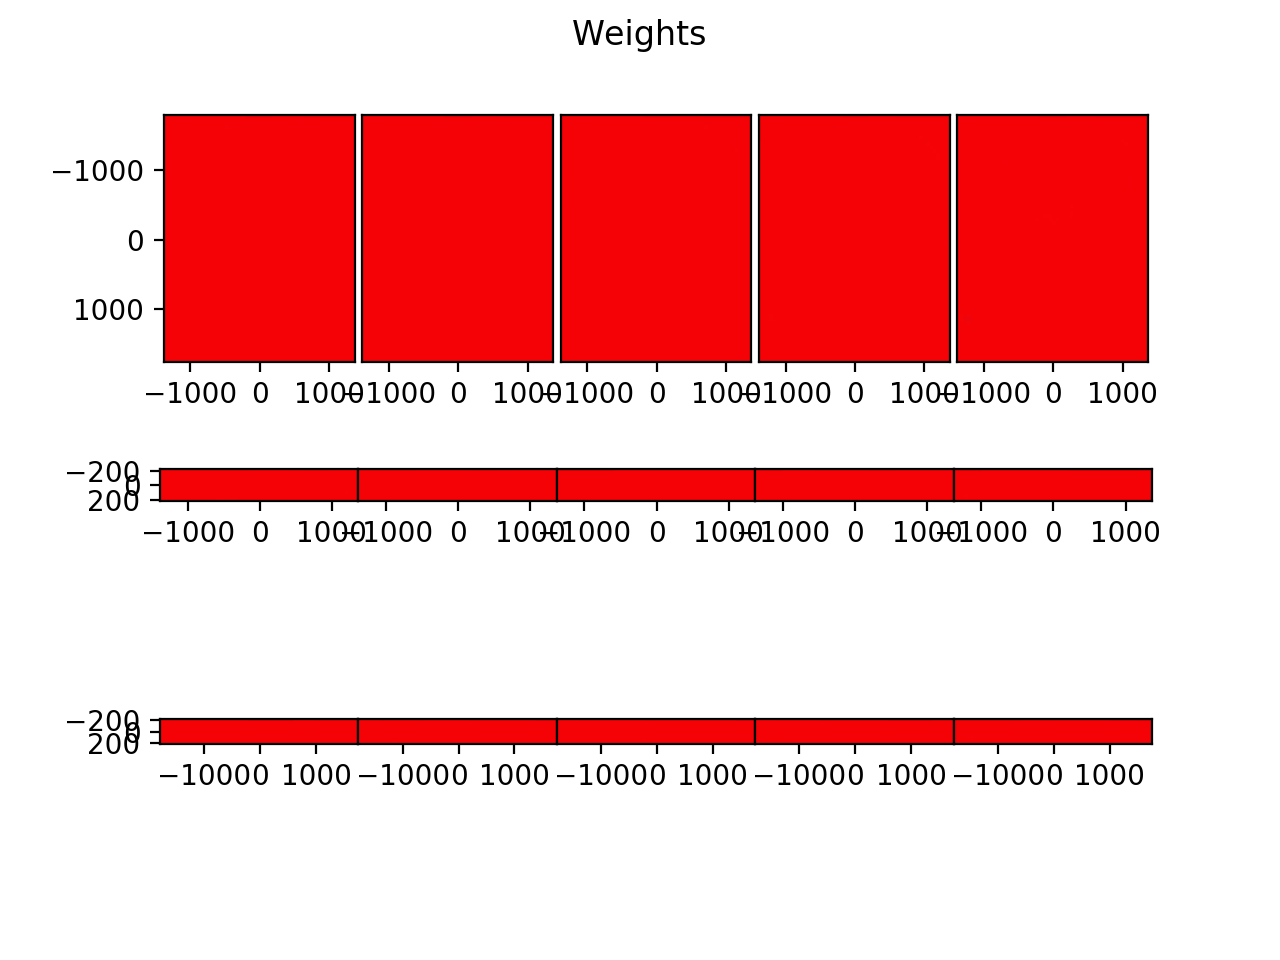

Finished iteration 0
Finished iteration 10
Finished iteration 20
Finished iteration 30
Finished iteration 40
Finished iteration 50
Finished iteration 60
Finished iteration 70
Finished iteration 80
Finished iteration 90
Finished iteration 100
Iteration 110, translation oscilating, reducing eA to 225000.0
Finished iteration 110
Finished iteration 120
Finished iteration 130
Finished iteration 140
Iteration 150, translation oscilating, reducing eA to 202500.0
Finished iteration 150
Iteration 160, translation oscilating, reducing eA to 182250.0
Finished iteration 160
Iteration 170, translation oscilating, reducing eA to 164025.0
Finished iteration 170
Iteration 180, translation oscilating, reducing eA to 147622.5
Finished iteration 180
Iteration 190, translation oscilating, reducing eA to 132860.25
Finished iteration 190
Iteration 200, translation oscilating, reducing eA to 119574.225
Finished iteration 200
Iteration 210, translation oscilating, reducing eA to 107616.8025
Finished iteration

In [32]:
imp.reload(emlddmm)
# on the next run we do les downsampling
config2 = dict(config1)
config2['A'] = out1['A']
config2['n_iter']= 1000
config2['v'] = out1['v']
config2['downI'] = [1,1,1]
config2['downJ'] = [1,1,1]
config2['ev'] = config1['ev']*0.5
config2['eA'] = config1['eA']*0.5
# there seems to be an issue with the initial velocity
# when I run this twice, I'm reusing it
out2 = emlddmm.emlddmm(xI=xI,I=I_,xJ=xJ,J=J, W0=target_data['W'], **config2)
# the matching energy here is way way lower, why would that be?

In [34]:
# save the outputs
savename = 'transformation_outputs_dragonfly10to30_v00.npz'
np.savez(output_prefix+savename,out=out)

In [35]:
out2['figI'].savefig(output_prefix + 'transformed.jpg',**figopts)
out2['figfI'].savefig(output_prefix + 'contrast.jpg',**figopts)
out2['figErr'].savefig(output_prefix + 'err.jpg',**figopts)

4294967296 4294967296
4294967296 4294967296
4294967296 4294967296


In [36]:
fig = out2['figErr']
axs = fig.get_axes()
for ax in axs:
    ims = ax.get_images()
    for im in ims:
        im.set_cmap('twilight')
        clim = im.get_clim()
        lim = np.max(np.abs(clim))
        im.set_clim(np.array((-1,1))*lim)
fig.canvas.draw()
fig.savefig(output_prefix + 'err.jpg',**figopts)

4294967296 4294967296


starting to compose sequence with transforms [Transform with data size torch.Size([4, 4]), direction b, and domain <class 'NoneType'>, Transform with data size torch.Size([3, 4, 37, 51]), direction b, and domain <class 'list'>]


<IPython.core.display.Javascript object>


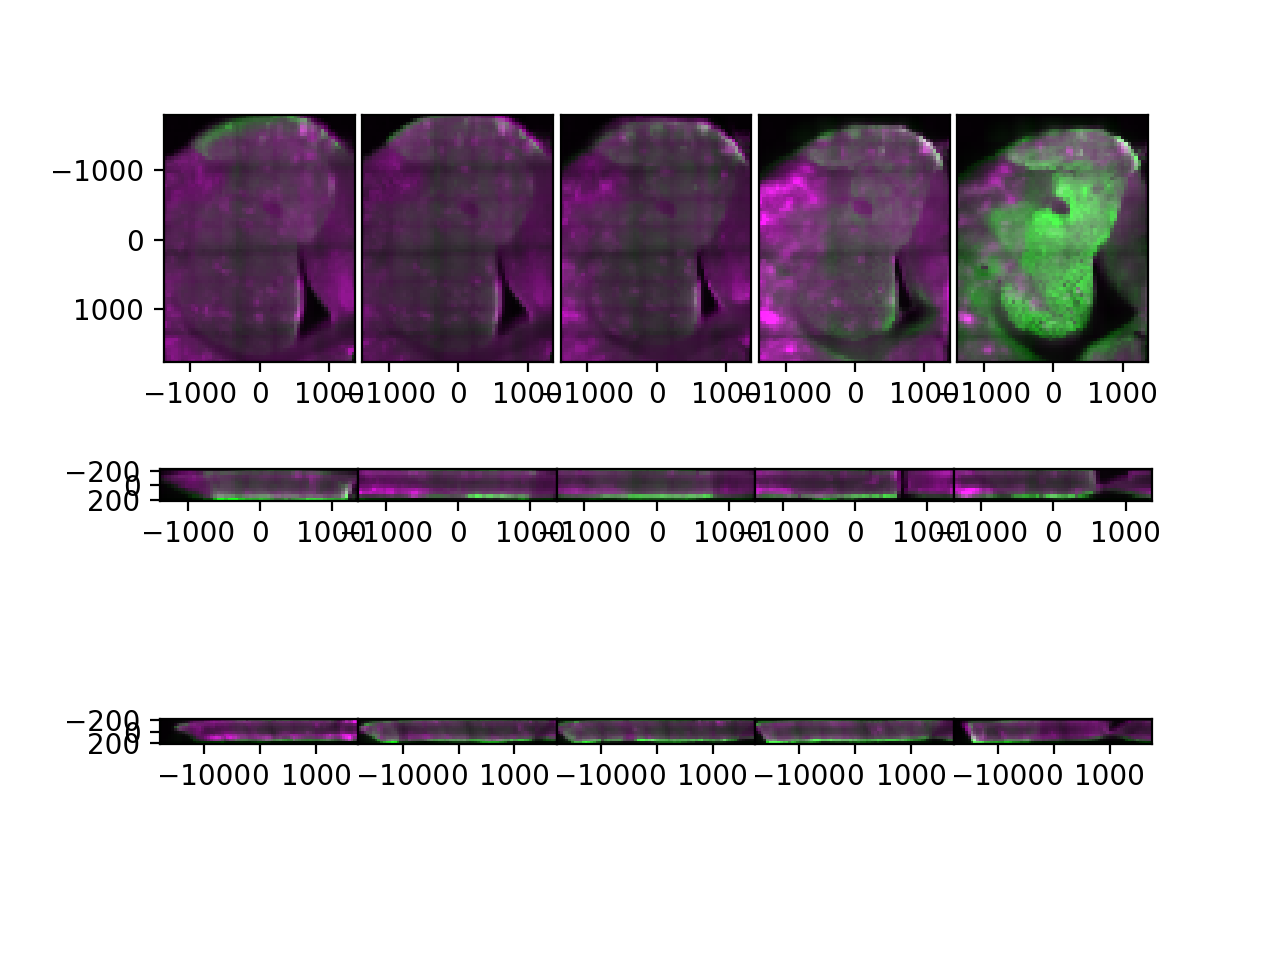

In [44]:
# vualize overlap as above

# check it
XJ = np.meshgrid(*xJ,indexing='ij')

tform = emlddmm.compose_sequence([emlddmm.Transform(out2['A'],'b'),
                                  emlddmm.Transform(out2['v'],'b',domain=out2['xv'])],XJ)
AI = emlddmm.apply_transform_float(xI,I,tform)
fig,ax = emlddmm.draw(np.concatenate((AI,J)),xJ,vmin=0)
fig.canvas.draw()


In [ ]:
# write the outputs

In [ ]:
asdf

In [37]:
# transform the labels
deformation = emlddmm.Transform(out2['v'],domain=out2['xv'],direction='b')
affine = emlddmm.Transform(out2['A'],direction='b')
tform = emlddmm.compose_sequence([affine,deformation],XJ)

starting to compose sequence with transforms [Transform with data size torch.Size([4, 4]), direction b, and domain <class 'NoneType'>, Transform with data size torch.Size([3, 4, 37, 51]), direction b, and domain <class 'list'>]


In [38]:
It = emlddmm.apply_transform_float(xI,I,tform).cpu().numpy()
RGBt = emlddmm.apply_transform_float(xI,RGB,tform).cpu().numpy()


NameError: name 'RGB' is not defined

In [ ]:
imp.reload(emlddmm)
St = emlddmm.apply_transform_int(xI,S,tform,double=True).cpu().numpy()

In [ ]:
fig,ax = emlddmm.draw(np.stack((It[0]*0.5,It[1]*0.5,Jsave[0]*1.5)),xJ,vmin=0,vmax=4)
fig.subplots_adjust(wspace=0,hspace=0,right=1)
fig,ax = emlddmm.draw(np.stack((It[0]*0.5,It[1]*0.5,Jsave[0]*1.5)),xJ,)
fig.subplots_adjust(wspace=0,hspace=0,right=1)

In [ ]:
fig,ax = emlddmm.draw(It,xJ)
fig.subplots_adjust(wspace=0,hspace=0,right=1)
fig.savefig('Isave.jpg')

In [ ]:
fig,ax = emlddmm.draw(J,xJ)
plt.subplots_adjust(wspace=0,hspace=0,right=1)
fig.savefig('Jsave.jpg')

In [ ]:
dI = [x[1] - x[0] for x in xI]
dJ = [x[1] - x[0] for x in xJ]
dI,dJ

In [ ]:
# transform the labels
deformation = emlddmm.Transform(out2['v'],domain=out2['xv'],direction='f')
affine = emlddmm.Transform(out2['A'],direction='f')
tformi = emlddmm.compose_sequence([deformation,affine,],XI)
#J_ = J0**0.25
J_ = np.copy(J)
Jt = emlddmm.apply_transform_float(xJ,J_,tformi).cpu().numpy()

In [ ]:
fig,ax = emlddmm.draw(Jt,xI,vmin=np.quantile(J_,0.02),vmax=np.quantile(J_,0.98))
fig.subplots_adjust(wspace=0,hspace=0,right=1)

In [ ]:
alpha = 0.3
fig = plt.figure(figsize=(7,7))
n = 4
slices = np.round(np.linspace(0,I.shape[1],n+2)[1:-1]).astype(int)
for i in range(n):
    ax = fig.add_subplot(3,n,i+1)    
    
    # get slices
    RGB_ = RGB[:,slices[i]].transpose(1,2,0)
    S_ = S[0,slices[i]]
    Jt_ = np.copy(Jt[0,slices[i]])
    Jt_ -= np.quantile(Jt_,0.01)
    Jt_ /= np.quantile(Jt_,0.99)
    # find boundaries
    border = S_ != np.roll(S_,shift=1,axis=0)
    border |= S_ != np.roll(S_,shift=-1,axis=0)
    border |= S_ != np.roll(S_,shift=1,axis=1)
    border |= S_ != np.roll(S_,shift=-1,axis=1)
    
    # draw
    ax.imshow(alpha*border[...,None]*RGB_ + ((1-alpha*border)*Jt_)[...,None])
    if i>0:
        ax.set_xticks([])
        ax.set_yticks([])
    
slices = np.round(np.linspace(0,I.shape[2],n+2)[1:-1]).astype(int)
for i in range(n):
    ax = fig.add_subplot(3,n,i+1 + n)    
    
    # get slices
    RGB_ = RGB[:,:,slices[i]].transpose(1,2,0)
    S_ = S[0,:,slices[i]]
    Jt_ = np.copy(Jt[0,:,slices[i]])
    Jt_ -= np.quantile(Jt_,0.01)
    Jt_ /= np.quantile(Jt_,0.99)
    # find boundaries
    border = S_ != np.roll(S_,shift=1,axis=0)
    border |= S_ != np.roll(S_,shift=-1,axis=0)
    border |= S_ != np.roll(S_,shift=1,axis=1)
    border |= S_ != np.roll(S_,shift=-1,axis=1)
    
    # draw
    ax.imshow(alpha*border[...,None]*RGB_ + ((1-alpha*border)*Jt_)[...,None])
    if i>0:
        ax.set_xticks([])
        ax.set_yticks([])

slices = np.round(np.linspace(0,I.shape[3],n+2)[1:-1]).astype(int)
for i in range(n):
    ax = fig.add_subplot(3,n,i+1 + n+n)    
    
    # get slices
    RGB_ = RGB[:,:,:,slices[i]].transpose(1,2,0)
    S_ = S[0,:,:,slices[i]]
    Jt_ = np.copy(Jt[0,:,:,slices[i]])
    Jt_ -= np.quantile(Jt_,0.01)
    Jt_ /= np.quantile(Jt_,0.99)
    # find boundaries
    border = S_ != np.roll(S_,shift=1,axis=0)
    border |= S_ != np.roll(S_,shift=-1,axis=0)
    border |= S_ != np.roll(S_,shift=1,axis=1)
    border |= S_ != np.roll(S_,shift=-1,axis=1)
    
    # draw
    ax.imshow(alpha*border[...,None]*RGB_ + ((1-alpha*border)*Jt_)[...,None])    
    if i>0:
        ax.set_xticks([])
        ax.set_yticks([])
fig.suptitle('Atlas space')
fig.subplots_adjust(wspace=0,hspace=0,left=0.0,right=1,bottom=0,top=0.95)
fig.savefig(output_prefix+'atlas_space.jpg',**figopts)

In [ ]:
alpha = 0.4
fig = plt.figure(figsize=(8,5))
n = 4
slices = np.round(np.linspace(0,J.shape[1],n+2)[1:-1]).astype(int)
for i in range(n):
    ax = fig.add_subplot(3,n,i+1)    
    
    # get slices
    RGB_ = RGBt[:,slices[i]].transpose(1,2,0)
    S_ = St[0,slices[i]]
    Jt_ = np.copy(J[0,slices[i]])
    Jt_ -= np.quantile(Jt_,0.01)
    Jt_ /= np.quantile(Jt_,0.99)
    # find boundaries
    border = S_ != np.roll(S_,shift=1,axis=0)
    border |= S_ != np.roll(S_,shift=-1,axis=0)
    border |= S_ != np.roll(S_,shift=1,axis=1)
    border |= S_ != np.roll(S_,shift=-1,axis=1)
    
    # draw
    ax.imshow(alpha*border[...,None]*RGB_ + ((1-alpha*border)*Jt_)[...,None])
    if i>0:
        ax.set_xticks([])
        ax.set_yticks([])
    
slices = np.round(np.linspace(0,J.shape[2],n+2)[1:-1]).astype(int)
for i in range(n):
    ax = fig.add_subplot(3,n,i+1 + n)    
    
    # get slices
    RGB_ = RGBt[:,:,slices[i]].transpose(1,2,0)
    S_ = St[0,:,slices[i]]
    Jt_ = np.copy(J[0,:,slices[i]])
    Jt_ -= np.quantile(Jt_,0.01)
    Jt_ /= np.quantile(Jt_,0.99)
    # find boundaries
    border = S_ != np.roll(S_,shift=1,axis=0)
    border |= S_ != np.roll(S_,shift=-1,axis=0)
    border |= S_ != np.roll(S_,shift=1,axis=1)
    border |= S_ != np.roll(S_,shift=-1,axis=1)
    
    # draw
    ax.imshow(alpha*border[...,None]*RGB_ + ((1-alpha*border)*Jt_)[...,None])
    if i>0:
        ax.set_xticks([])
        ax.set_yticks([])

slices = np.round(np.linspace(0,J.shape[3],n+2)[1:-1]).astype(int)
for i in range(n):
    ax = fig.add_subplot(3,n,i+1 + n+n)    
    
    # get slices
    RGB_ = RGBt[:,:,:,slices[i]].transpose(1,2,0)
    S_ = St[0,:,:,slices[i]]
    Jt_ = np.copy(J[0,:,:,slices[i]])
    Jt_ -= np.quantile(Jt_,0.01)
    Jt_ /= np.quantile(Jt_,0.99)
    # find boundaries
    border = S_ != np.roll(S_,shift=1,axis=0)
    border |= S_ != np.roll(S_,shift=-1,axis=0)
    border |= S_ != np.roll(S_,shift=1,axis=1)
    border |= S_ != np.roll(S_,shift=-1,axis=1)
    
    # draw
    ax.imshow(alpha*border[...,None]*RGB_ + ((1-alpha*border)*Jt_)[...,None])    
    if i>0:
        ax.set_xticks([])
        ax.set_yticks([])
fig.suptitle('Target space')
fig.subplots_adjust(wspace=0,hspace=0,left=0.0,right=1,bottom=0,top=0.95)
fig.savefig(output_prefix+'target_space.jpg',**figopts)